In [4]:
import numpy as np
import scipy
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')
# A helper function for downloading files
import requests
import os
def download(url, local_filename=None):
    """
    Downloads the file in the ``url`` and saves it in the current working directory.
    """
    data = requests.get(url)
    if local_filename is None:
        local_filename = os.path.basename(url)
    with open(local_filename, 'wb') as fd:
        fd.write(data.content)
import math
import tqdm

# Hands-on Activity 27.3 - The Metropolis-Hastings Algorithm

## Objectives

+ Use the Metropolis-Hastings algorithm (the most general Markov Chain Monte Carlo (MCMC) algorithm) to sample from an arbitrary probability density known up to a normalization constant.
+ Build new algorithms with Metropolis-Hastings. Example: Metrpolis Adjusted Langevin Dynamics.
+ Combining transition kernels using (approximate) Gibbs sampling to sample from complicated joint distributions.
+ Use MCMC to calibrate the reaction kinetics problem using the Bayesian formulation.

## Readings

+ Chapter 11 of Bishop.
+ These notes.

## Metropolis Adjusted Langevin Dynamics (MALA)

Here is a basic implementation of the MALA algorithm we introduced in the lecture.

In [7]:
def mala(x0, log_h, n, dt, args=()):
    """
    Random walk metropolis.
    
    :param x0:     The initial point (numpy array).
    :param log_h:  The logartihm of the function that is proportional to the density you want to sample from (function).
                   Returns also the gradient.
    :param n:      The maximum number of steps you want to take.
    :param dt:     The time step you want to use.
    :param args:   Any parameters to log_h
    
    :returns:  X, acceptance_rate
    """
    x0 = np.array(x0)
    assert x0.ndim == 1
    # Dimensionality of space
    d = x0.shape[0]
    # A place to store the samples
    X = np.ndarray((n + 1, d))
    X[0, :] = x0
    # Previous value of log(h(x))
    log_h_p, grad_log_h_p = log_h(x0, *args)

    # Keep track of how many samples are accepted
    count_accepted = 0
    # Start the simulation
    for t in tqdm.tqdm(range(1, n + 1)):
        # Generation
        x = X[t - 1, :] + dt * grad_log_h_p + np.sqrt(2. * dt) * np.random.randn(d)
        # Calculation
        log_h_c, grad_log_h_c = log_h(x, *args) # Current value of log(h(x))
        log_alpha_1 = log_h_c - log_h_p
        log_T_p_to_c = -np.sum((x - X[t - 1, :] - dt * grad_log_h_p) ** 2 / (4. * dt))
        log_T_c_to_p = -np.sum((x + dt * grad_log_h_c - X[t - 1, :]) ** 2 / (4. * dt))
        log_alpha_2 = log_T_c_to_p - log_T_p_to_c
        log_alpha = log_alpha_1 + log_alpha_2
        alpha = min(1, np.exp(log_alpha))
        # Accept/Reject
        u = np.random.rand()
        if u <= alpha: # Accept
            X[t, :] = x
            log_h_p = log_h_c
            grad_log_h_p = grad_log_h_c
            count_accepted += 1
        else:          # Reject
            X[t, :] = X[t - 1, :]
    # Empirical acceptance rate
    acceptance_rate = count_accepted / (1. * n)
    return X, acceptance_rate

## Example 1: Sampling from a Gaussian with MALA

Let's take $\mathcal{X}=\mathbb{R}^2$ and:
$$
\pi(x) \propto h(x) = \exp\left\{-\frac{1}{2}\left(x-\mu\right)^T\Lambda(x-\mu)\right\},
$$
where $\mu\in\mathbb{R}^2$ is the mean and $\Lambda = \Sigma^{-1}\in\mathbb{R}^{2\times 2}$ is the precision matrix.
We need:
$$
\log h(x) = -\frac{1}{2}(x-\mu)^T\Lambda (x-\mu),
$$
and
$$
\nabla \log h(x) = -\Lambda (x-\mu).
$$

In [8]:
def log_h_mvn(x, mu, Lambda):
    tmp = x - mu
    return -0.5 * np.dot(tmp, np.dot(Lambda, tmp)), -np.dot(Lambda, x - mu)

# The parameters of the disribution from which we wish to sample
mu = np.array([5., 2.])
Sigma = np.array([[1., .4],
                  [.3, 0.2]]) # This has to be positive definite - otherwise you will get garbage!
Lambda = np.linalg.inv(Sigma)

# Initialiazation:
x0 = np.random.randn(2)
# Parameters of the proposal:
dt = 0.15
# Number of steps:
n = 10000

# Start sampling
X, acceptance_rate = mala(x0, log_h_mvn, n, dt, args=(mu, Lambda))

print('Acceptance rate: %1.2f' % acceptance_rate)

100%|██████████| 10000/10000 [00:00<00:00, 24011.63it/s]

Acceptance rate: 0.46


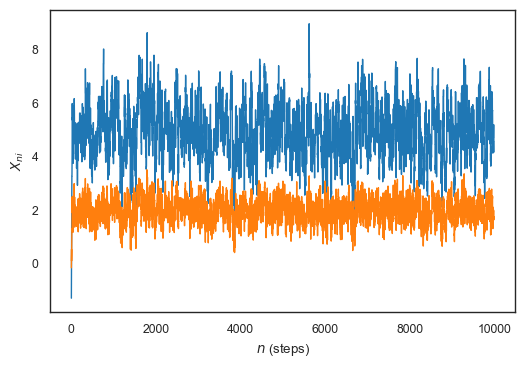

In [9]:
fig, ax = plt.subplots()
ax.plot(range(n + 1), X, lw=1)
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$X_{ni}$');

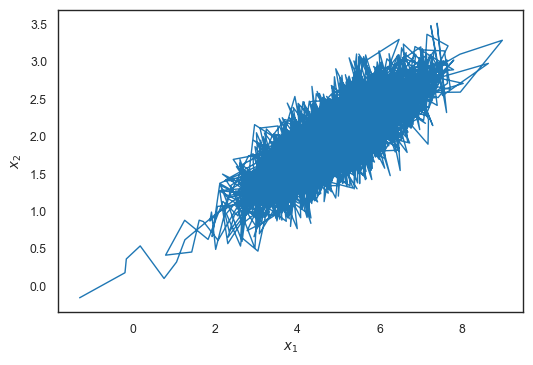

In [10]:
fig, ax = plt.subplots()
ax.plot(X[:, 0], X[:, 1], lw=1)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

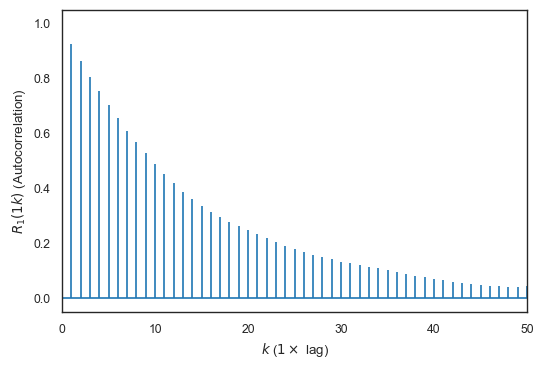

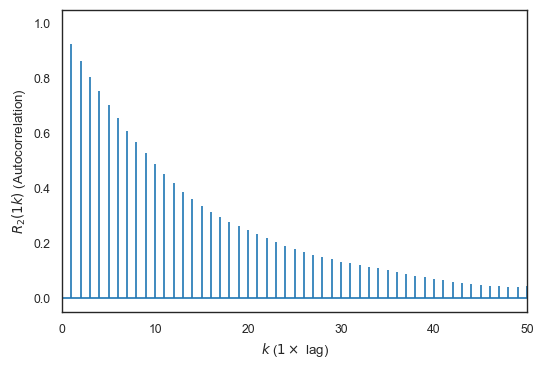

In [11]:
# How many samples do you want to burn?
burn = 500
# How many samples do you want to throw in between?
thin = 1 # Keep one every ten samples (k*)
# Here are the remaining samples:
X_rest = X[burn::thin]
for i in range(X_rest.shape[1]):
    fig, ax = plt.subplots()
    ax.acorr(X_rest[:, 0], detrend=plt.mlab.detrend_mean, maxlags=50)
    ax.set_xlim(0, 50)
    ax.set_ylabel('$R_{%d}(%d k)$ (Autocorrelation)' % (i + 1, thin))
    ax.set_xlabel(r'$k$ ($%d \times$ lag)' % thin);

## Example 2: The Catalysis Problem Revisited
For the full details of this problem, please see Lectures 19-20.
We will use the following prior:
$$
p(x) = \mathcal{N}(0,\gamma^2I).
$$
We need a prior on $\sigma$.
Let's pick:
$$
p(\sigma) \propto \frac{1}{\sigma}.
$$
We want to treat $\sigma$ and $x$ in the same way (one sampler), so let's introduce the following unknown vector to be inferred from the data:
$$
z = (x, \theta),
$$
where
$$
\theta = \log\sigma.
$$
On [Lecture 20](handout_20.ipynb) we saw that:
$$
p(\theta) \propto 1.
$$
Our posterior is for $z$ is:
$$
\pi(z) = p(z|y) \propto p(y|z)p(z) \propto h(z) = e^{-m\theta}\exp\left\{-\frac{\parallel y - f(x) \parallel_2^2}{2e^{2\theta}}-\frac{1}{2\gamma^2}\parallel x\parallel_2^2\right\}.
$$

For MALA, we need:
$$
\log h(z) = -m\theta -\frac{1}{2}e^{-2\theta}\parallel y - f(x) \parallel_2^2 -\frac{1}{2\gamma^2}\parallel x\parallel_2^2,
$$
$$
\nabla_x \log h(z) = e^{-2\theta}(y-f(x))^T\nabla_x f(x) - \gamma^{-2}x,
$$
and
$$
\frac{\partial h(z)}{\partial \theta} = -m + e^{-2\theta}\parallel y - f(x) \parallel_2^2.
$$

**WARNING:** The code below will take at least 30 minutes.

In [16]:
# The data
#import pandas as pd
#import io
#import requests
#url="https://raw.githubusercontent.com/PredictiveScienceLab/uq-course/master/lectures/catalysis.csv"
#download(url)
catalysis_data = pd.read_csv('catalysis.csv', index_col=0)

# The experimental data as a matrix
Y = catalysis_data[1:].values

# The experimental as a vector
y = Y.flatten()

# The model
from demos.catalysis import CatalysisModel
solver = CatalysisModel()  


# This is what we need for MALA
def log_h_cat(z, y, gamma):
    m = y.shape[0]
    x = z[:5]
    theta = z[5]
    sigma = np.exp(theta)
    k = np.exp(x) / 180.
    sol = solver(k)
    f = sol['f'][0][5:]
    dfdk = sol['f_grad'][0][5:, :]
    dfdx = np.einsum('ij,j->ij', dfdk, k)
    tmp = (y - f)
    log_h = -m * theta - 0.5 * np.sum(tmp ** 2) / sigma ** 2 - 0.5 * np.sum(x ** 2) / gamma ** 2
    grad_x_log_h = np.einsum('ij,i->j', dfdx, tmp) / sigma ** 2 - x / gamma ** 2
    grad_theta_log_h = - m + np.sum(tmp ** 2) / sigma ** 2
    grad_log_h = np.hstack([grad_x_log_h, [grad_theta_log_h]])
    return log_h, grad_log_h


def m_log_h_cat(z, y, gamma):
    tmp1, tmp2 = log_h_cat(z, y, gamma)
    return -tmp1, -tmp2

In [17]:
# Any parameters we fix - RUNNING THIS WILL TAKE QUITE A BIT OF TIME
gamma = 10.

# Initialiazation:
x0 = np.random.randn(5)
sigma = 10.
theta = np.log(sigma)
z0 = np.hstack([x0, [theta]])

# Maximize posterior to select initial point
res = scipy.optimize.minimize(m_log_h_cat, z0, jac=True, args=(y, gamma))

# Parameters of the proposal:
dt = 1e-3

# Number of steps:
n = 1000

# Start sampling
Z, acceptance_rate = mala(res.x, log_h_cat, n, dt, args=(y, gamma))

print('Acceptance rate: %1.2f' % acceptance_rate)

/Users/iliasbilionis/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ode.py:1012: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  self.messages.get(istate, unexpected_istate_msg)))
100%|██████████| 1000/1000 [03:01<00:00,  5.52it/s]

Acceptance rate: 0.71


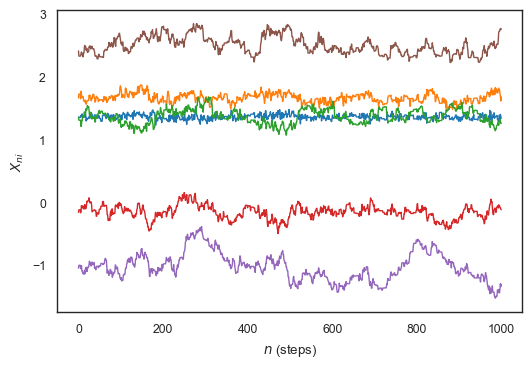

In [18]:
fig, ax = plt.subplots()
ax.plot(range(n + 1), Z, lw=1)
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$X_{ni}$');

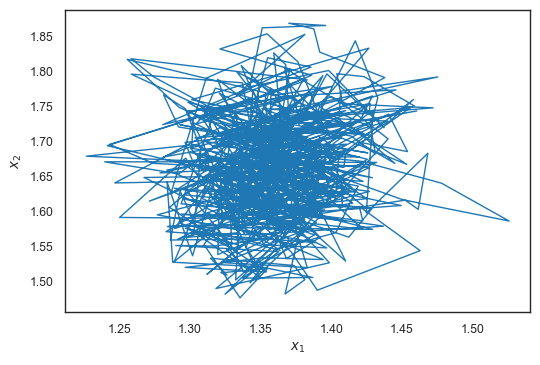

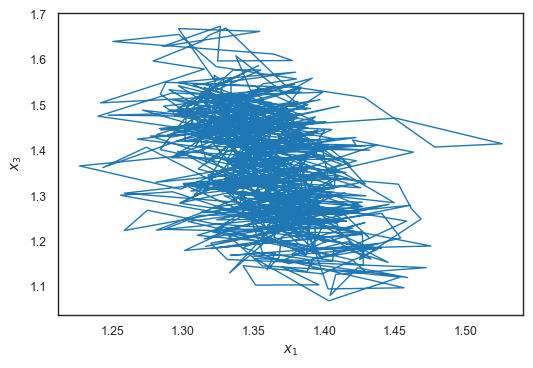

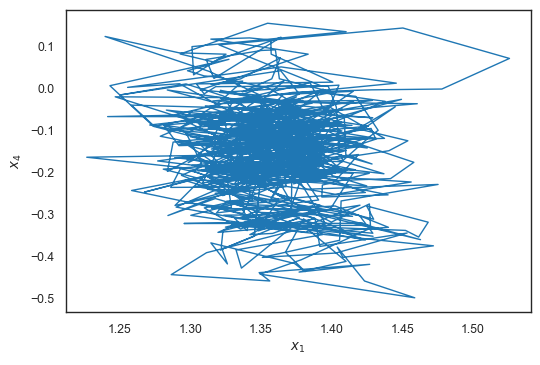

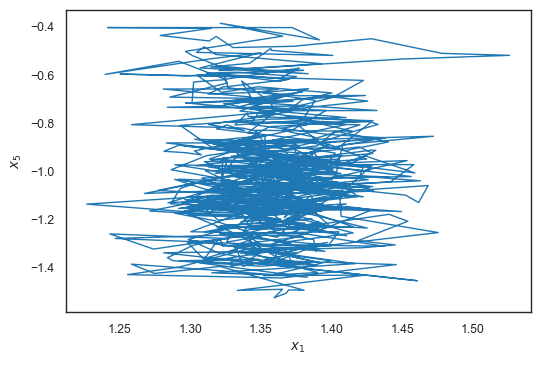

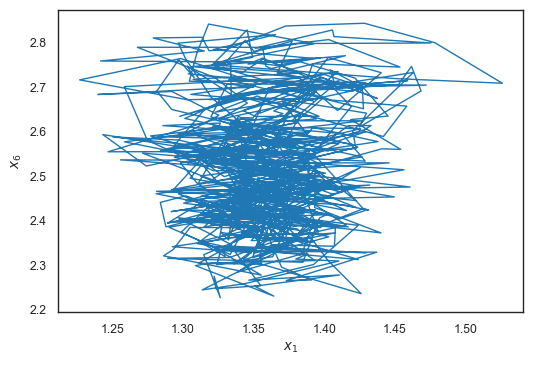

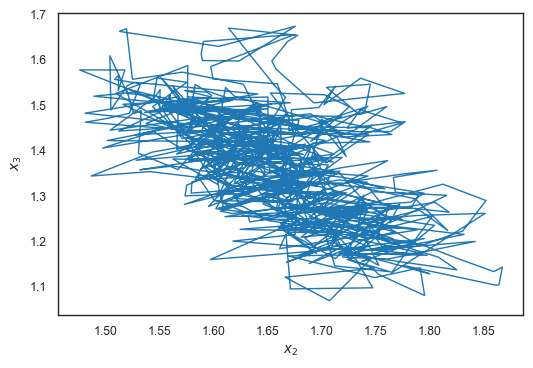

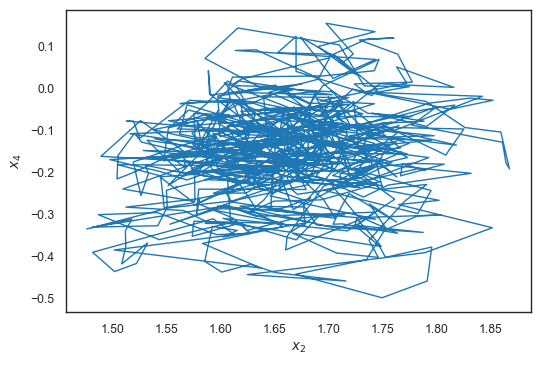

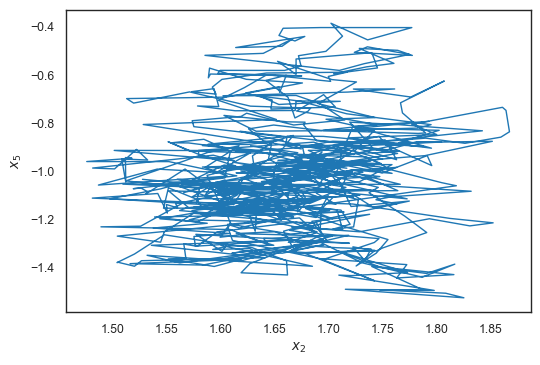

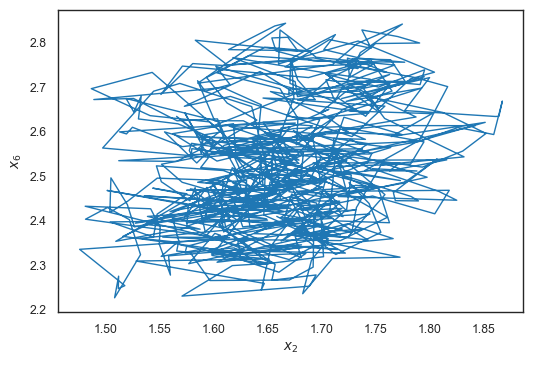

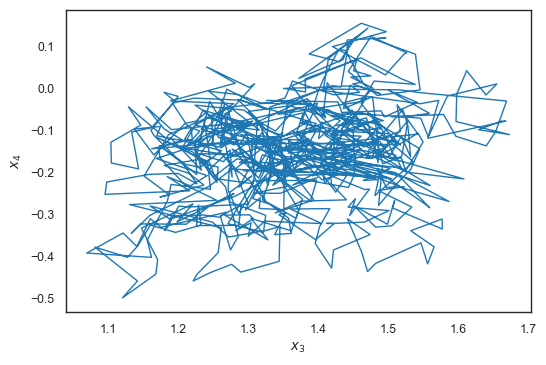

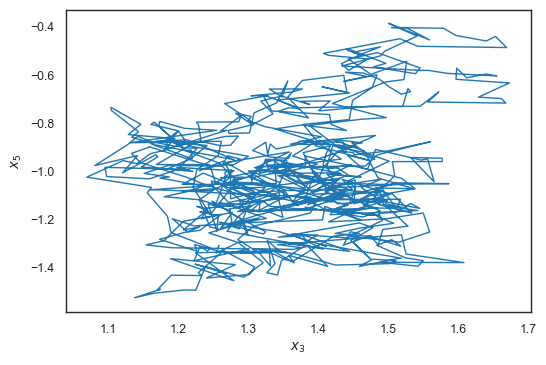

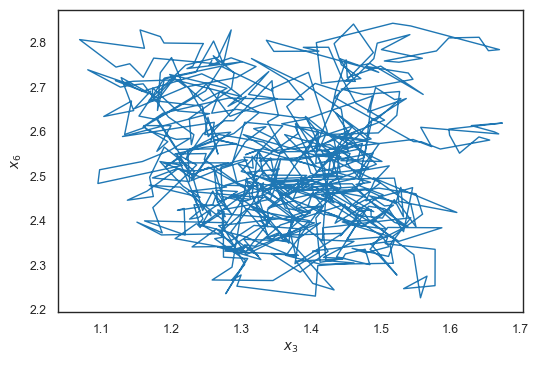

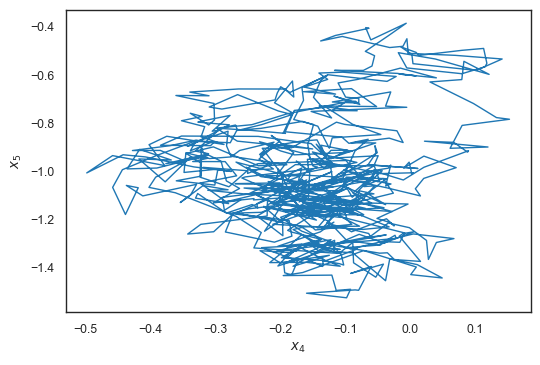

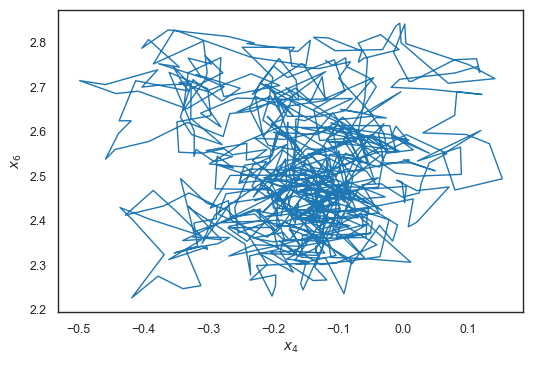

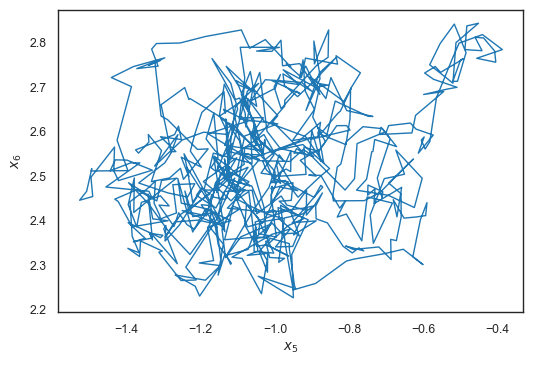

In [19]:
# Draw all pairwise scatter plots
for i in range(Z.shape[1]):
    for j in range(i + 1, Z.shape[1]):
        fig, ax = plt.subplots()
        ax.plot(Z[:, i], Z[:, j], lw=1)
        ax.set_xlabel('$x_{%d}$' % (i + 1))
        ax.set_ylabel('$x_{%d}$' % (j + 1));

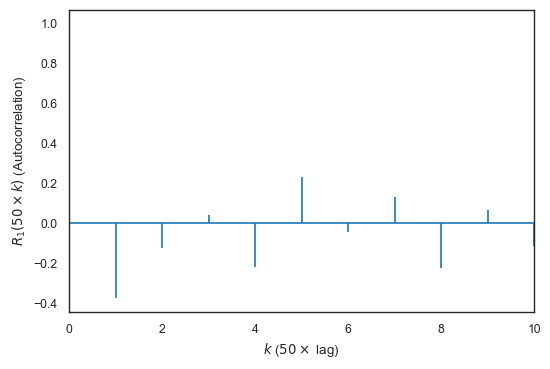

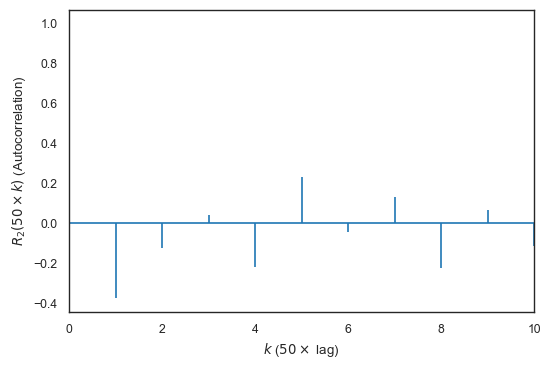

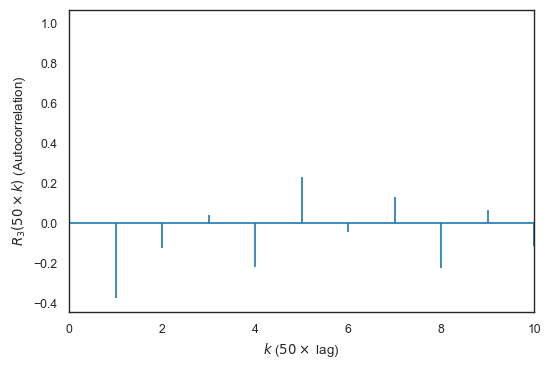

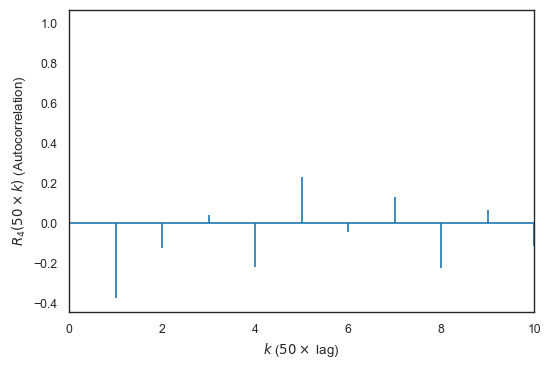

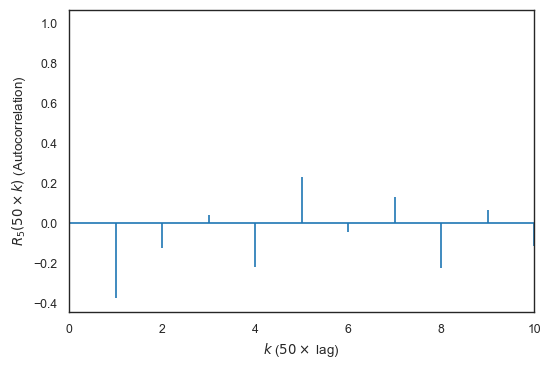

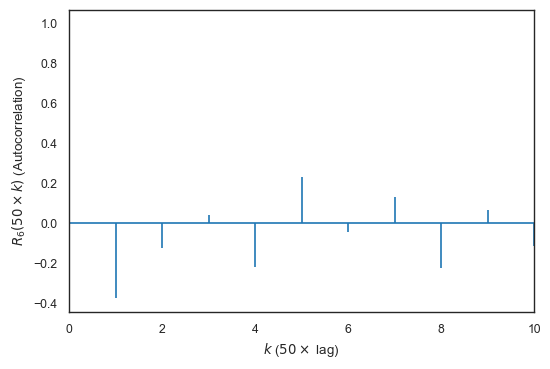

In [20]:
# How many samples do you want to burn?
burn = 1
# How many samples do you want to throw in between?
thin = 50 # Keep one every ten samples (k*)
# Here are the remaining samples:
Z_rest = Z[burn::thin]
for i in range(Z_rest.shape[1]):
    fig, ax = plt.subplots()
    ax.acorr(Z_rest[:, 0], detrend=plt.mlab.detrend_mean, maxlags=10)
    ax.set_xlim(0, 10)
    ax.set_ylabel(r'$R_{%d}(%d \times k)$ (Autocorrelation)' % (i + 1, thin))
    ax.set_xlabel(r'$k$ ($%d \times$ lag)' % thin);

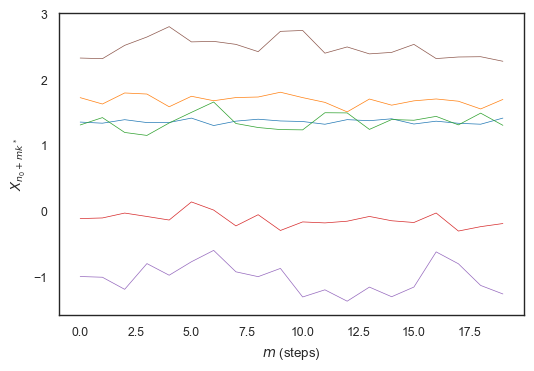

In [21]:
fig, ax = plt.subplots()
ax.plot(Z_rest, lw=0.5)
ax.set_xlabel('$m$ (steps)')
ax.set_ylabel('$X_{n_0+m k^*}$');

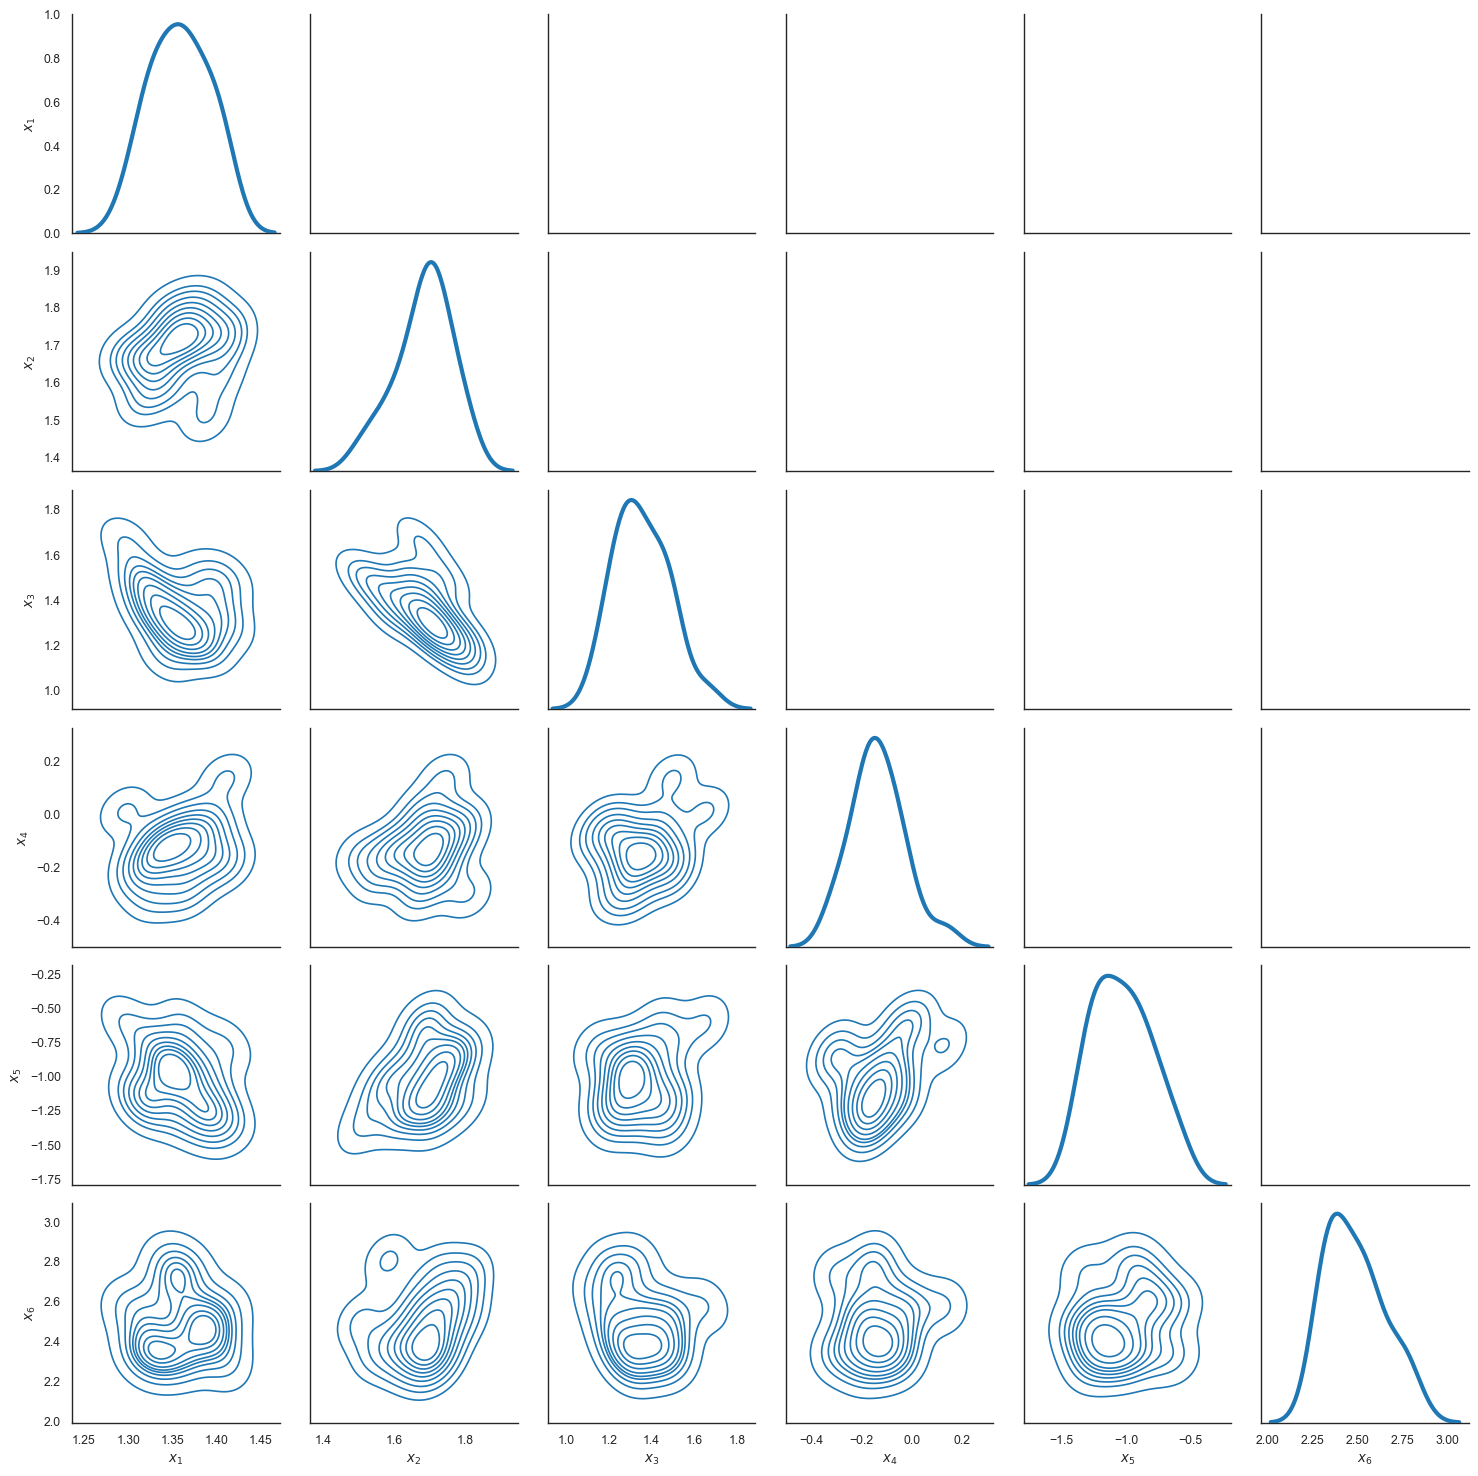

In [22]:
# Now let's do all the pairwise scatter plots for the x-s.
df = pd.DataFrame(Z_rest, columns=['$x_{%d}$' % (i + 1) for i in range(Z_rest.shape[1])])
gg = sns.PairGrid(df, diag_sharey=False)
gg.map_lower(sns.kdeplot)
gg.map_upper(plt.scatter)
gg.map_diag(sns.kdeplot, lw=3);

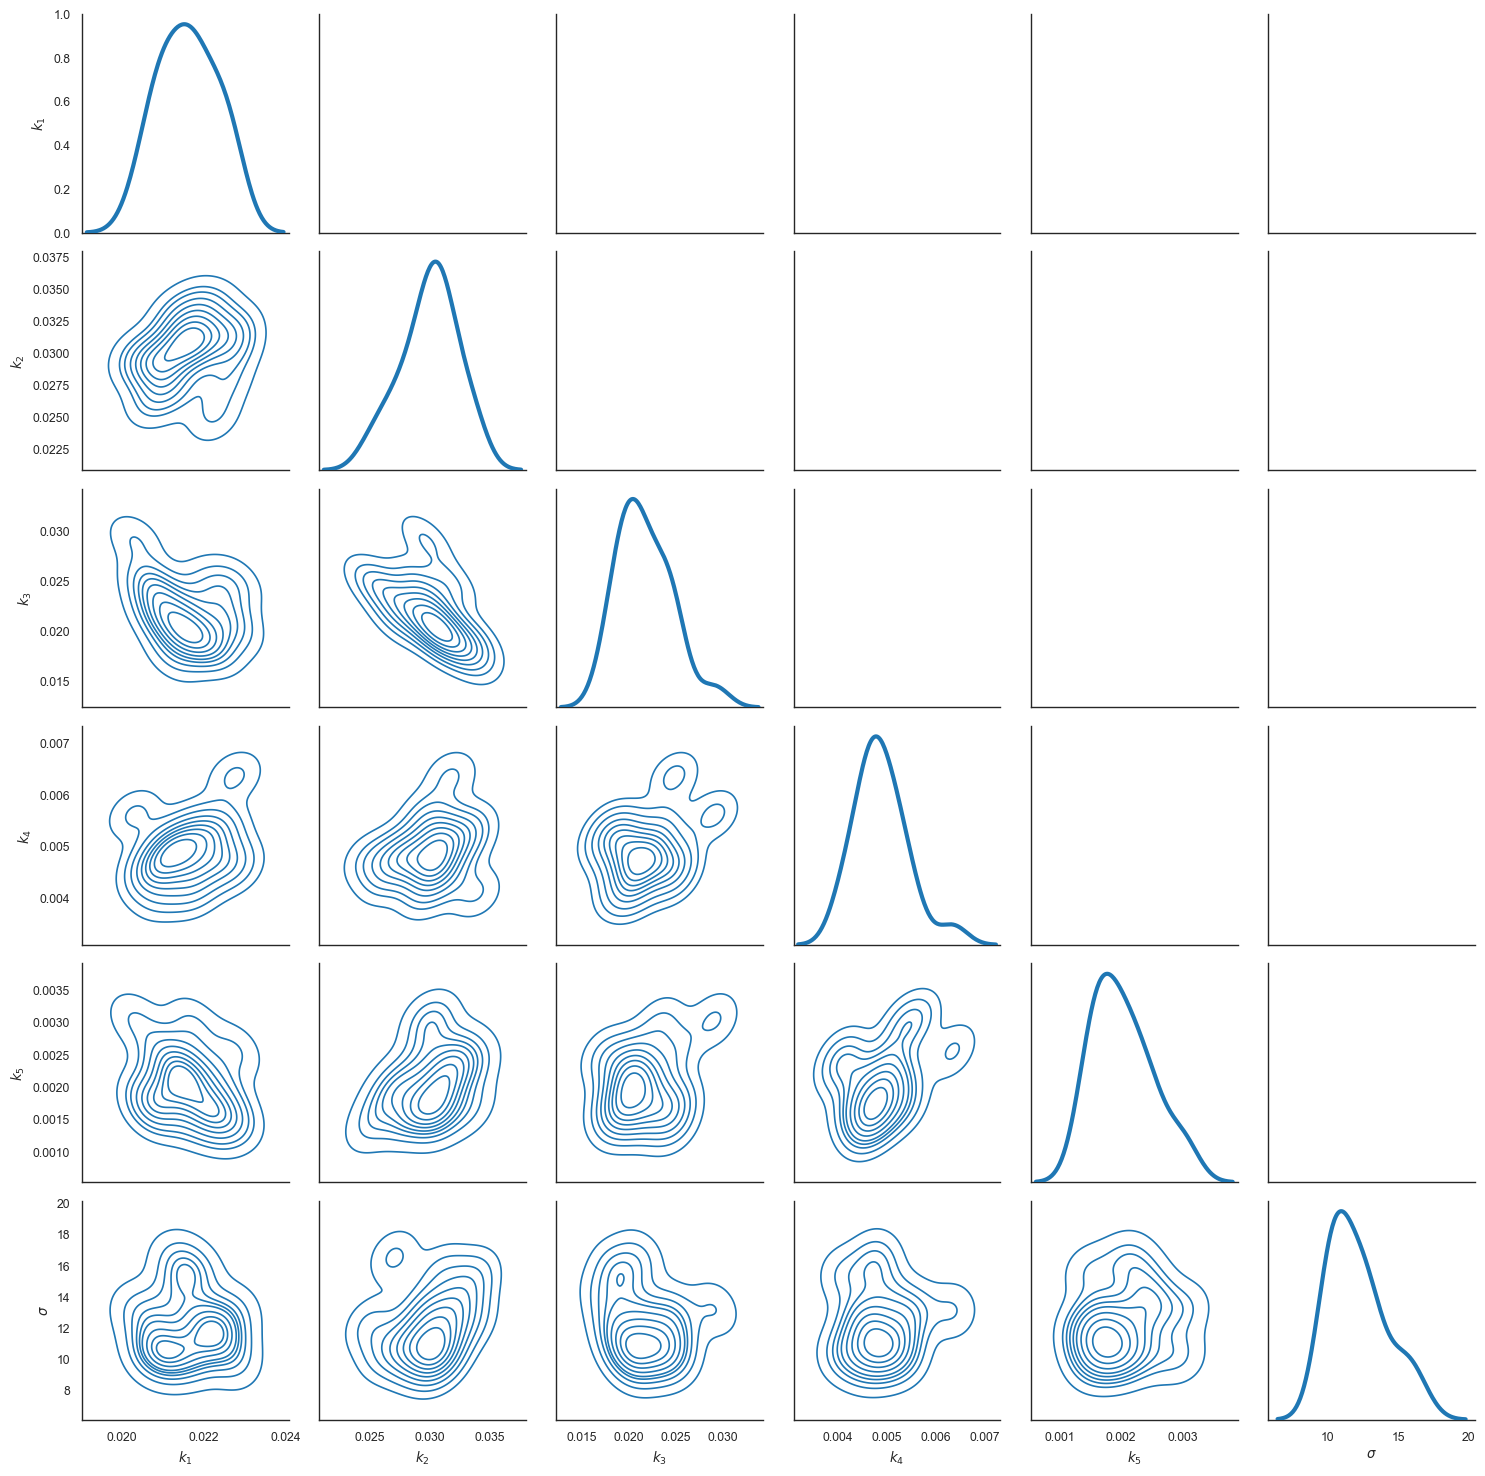

In [23]:
# Now let's transform back to our k's and repeat the procedure
K_rest = np.exp(Z_rest[:, :-1]) / 180.
sigmas = np.exp(Z_rest[:, -1])
Z_rest_trans = np.hstack([K_rest, sigmas[:, None]])
df = pd.DataFrame(Z_rest_trans, columns=['$k_{%d}$' % (i + 1) for i in range(K_rest.shape[1])] + ['$\sigma$'])
gg = sns.PairGrid(df, diag_sharey=False)
gg.map_lower(sns.kdeplot)
gg.map_upper(plt.scatter)
gg.map_diag(sns.kdeplot, lw=3);

In [68]:
# Now, let us compute the statistics of the response.
# Note that what we are doing here is a little bit stupid.
# With better book-keeping we could avoid resolving the dynamical system at every sample.
# We will see how we can exploit packages like pymc to do the book-keeping for us.
t = np.linspace(0, 180, 200)
Y_rest = np.ndarray((K_rest.shape[0], 7, 5))
for (i, k) in enumerate(K_rest):
    f = solver(k)
    Y_rest[i, :, :] = f['f'].reshape((7, 5))

In [70]:
# Now we can do all sorts of statistics:
Y_median = np.median(Y_rest, axis=0)
# Predictive lower bound - Remove/Add the last term if you only want epistemic uncertainty
Y_lower = np.percentile(Y_rest, 2.5, axis=0) #- 1.96 * sigma
# Predictive upper bound - Remove/Add the last term if you only want epistemic uncertainty
Y_upper = np.percentile(Y_rest, 97.5, axis=0) #+ 1.96 * sigma

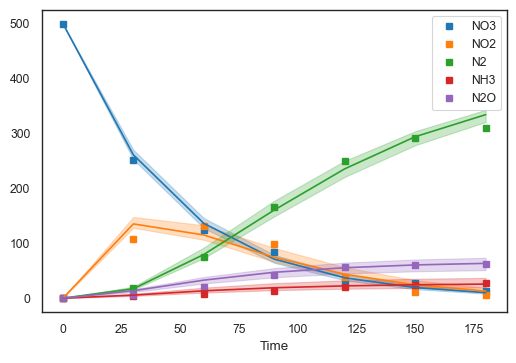

In [76]:
t = catalysis_data.index
fig, ax = plt.subplots(dpi=100)
catalysis_data.plot(ax=ax, style='s')
ax.plot(t, Y_median[:, 0], color=sns.color_palette()[0], label='Model NO3-')
ax.plot(t, Y_median[:, 1], color=sns.color_palette()[1], label='Model NO2-')
ax.plot(t, Y_median[:, 2], color=sns.color_palette()[2], label='Model N2')
ax.plot(t, Y_median[:, 3], color=sns.color_palette()[3], label='Model NH3')
ax.plot(t, Y_median[:, 4], color=sns.color_palette()[4], label='Model N2O')
ax.fill_between(t, Y_lower[:, 0], Y_upper[:, 0], color=sns.color_palette()[0], alpha=0.25)
ax.fill_between(t, Y_lower[:, 1], Y_upper[:, 1], color=sns.color_palette()[1], alpha=0.25)
ax.fill_between(t, Y_lower[:, 2], Y_upper[:, 2], color=sns.color_palette()[2], alpha=0.25)
ax.fill_between(t, Y_lower[:, 3], Y_upper[:, 3], color=sns.color_palette()[3], alpha=0.25)
ax.fill_between(t, Y_lower[:, 4], Y_upper[:, 4], color=sns.color_palette()[4], alpha=0.25);

### Questions

+ Are the steps we took sufficient? Increase ``n`` (the number of steps) and observe how the results change. You will have to wait. Go for a walk while this runs.

## Example 3: The Catalysis Problem Revisited

Let's see how we can use approximate Gibbs sampling to estimate both $\sigma^2$ and $\gamma^2$ along side $x$.
The prior for $\sigma^2$ (after following the standard tranformation formula) is:
$$
p(\sigma^2) \propto \sigma^{-2}.
$$
We assign the same unininformative prior to $\gamma^2$:
$$
p(\gamma^2) \propto \gamma^{-2}.
$$

The posterior of all our parameters are:
$$
\begin{array}{ccc}
p(x,\sigma^2,\gamma^2|y) &\propto& p(y|x,\sigma^2)p(x|\gamma^2)p(\sigma^2)p(\gamma^2)\\
&=& \left(2\pi\sigma^2\right)^{-\frac{m}{2}}\exp\left\{-\frac{\parallel y-f(x)\parallel_2^2}{2\sigma^2}\right\}\left(2\pi\gamma^2\right)^{-\frac{d}{2}}\exp\left\{-\frac{\parallel x\parallel_2^2}{2\gamma^2}\right\}\sigma^{-2}\gamma^{-2}.
\end{array}
$$
Let's work out the conditionals.
We have:
$$
p(x|\sigma^2,\gamma^2, y) = \frac{p(x,\sigma^2,\gamma^2|y)}{p(\sigma^2,\gamma^2|y)} \propto \exp\left\{-\frac{\parallel y-f(x)\parallel_2^2}{2\sigma^2}-\frac{\parallel x\parallel_2^2}{2\gamma^2}\right\},
$$
for which, unfortunately, we can only use a standard Metropolis sampler.
For $\sigma^2$ we have:
$$
p(\sigma^2 | x, \gamma^2, y) = \frac{p(x,\sigma^2,\gamma^2|y)}{p(x,\gamma^2|y)} \propto \left(\sigma^2\right)^{-\frac{m}{2}-1}\exp\left\{-\frac{\parallel y-f(x)\parallel_2^2}{2\sigma^2}\right\},
$$
in which we recognize the PDF of the [inverse-gamma](https://en.wikipedia.org/wiki/Inverse-gamma_distribution) distribution:
$$
p(\sigma^2 | x, \gamma^2, y) = \mbox{Inv-Gamma}\left(\sigma^2\middle|\alpha=\frac{m}{2}, \beta=\frac{\parallel y-f(x)\parallel_2^2}{2}\right).
$$
From this density, it is possible to sample without the need of a Metrpolis step.
Similarly, for $\gamma^2$ we have:
$$
\begin{array}{ccc}
p(\gamma^2|x,\sigma^2,y) &=& \frac{p(x,\sigma^2,\gamma^2|y)}{p(x,\sigma^2|y)}\\
&\propto& \left(\gamma^2\right)^{-\frac{d}{2}-1}\exp\left\{-\frac{\parallel x\parallel_2^2}{2\gamma^2}\right\}\\
&=&\mbox{Inv-Gamma}\left(\gamma^2\middle|\alpha=\frac{d}{2}, \beta=\frac{\parallel x\parallel_2^2}{2}\right),
\end{array}
$$

So, an (approximate) Gibbs sampler for our catalysis problem would work as follows:

+ Pick initial $x_0$ and $\sigma_0^2$.

+ For $t=1,2,\dots$:
    
    + Sample $x_t$ from:
        $$
        p(x_t|\sigma_{t-1}^2, \gamma_{t-1}^2, y) \propto \exp\left\{-\frac{\parallel y-f(x)\parallel_2^2}{2\sigma_{t-1}^2}-\frac{\parallel x\parallel_2^2}{2\gamma_{t-1}^2}\right\},
        $$
      by doing one (or more) step(s) of a random walk metropolis with $x_{t-1}$ as the starting point.
      
    + Directly sample $\sigma_t^2$ from:
        $$
        p(\sigma_t^2|x_t, \gamma_{t-1}^2, y) = \mbox{Inv-Gamma}\left(\sigma^2_t\middle|\alpha=\frac{m}{2}, \beta=\frac{\parallel y-f(x_t)\parallel_2^2}{2}\right).
        $$
        
    + Directly sample $\gamma_t^2$ from:
        $$
        p(\gamma_t^2|x_t, \sigma_t^2, y) = \mbox{Inv-Gamma}\left(\gamma^2\middle|\alpha=\frac{d}{2}, \beta=\frac{\parallel x_t\parallel_2^2}{2}\right).
        $$

In [22]:
# This is what we need for the random walk metropolis
def log_cond_x(x, sigma2, gamma2, y):
    m = y.shape[0]
    k = np.exp(x) / 180.
    t_exp = np.linspace(0, 180, 7)
    res = cat_solver(x, t_exp)[1:, :]
    Z = np.hstack([res[:, :2], res[:, 3:]])
    f = Z.flatten()
    tmp = (y - f)
    log_h = - 0.5 * np.sum(tmp ** 2) / sigma2 - 0.5 * np.sum(x ** 2) / gamma2
    return log_h, f

In [24]:
# Approximate Gibbs Sampler
# Dimensions
m = y.shape[0]
d = 5
# Initialize
sigma20 = 100.
gamma20 = 1.
x0 = np.sqrt(gamma20) * np.random.randn(d)
# Total number of steps
n = 1000
# Random walk proposal step:
sigma_prop = 0.1
# Number of rwmetropolis steps per Gibbs step
num_rw_steps = 10
# Storage for the parameters
sigma2s = [sigma20]
gamma2s = [gamma20]
xs = [x0]
# Start the algorithm
ars_sum = 0.
for t in range(n):
    # Sample a few steps from p(x | sigma2, gamma2, y) using a random walk metropolis
    tmp, ar, other = rwmetropolis(xs[-1], log_cond_x, num_rw_steps, sigma_prop, args=(sigma2s[-1], gamma2s[-1], y))
    ars_sum += ar
    x_new = tmp[-1, :]
    f = other[-1]
    diff = y - f
    # Sample new sigma2:
    sigma2_new = st.invgamma(a=0.5 * m, scale=0.5 * np.sum(diff ** 2)).rvs()
    # Sample new gamma2
    gamma2_new = st.invgamma(a=0.5 * d, scale=0.5 * np.sum(x_new ** 2)).rvs()
    # Store samples
    xs.append(x_new)
    sigma2s.append(sigma2_new)
    gamma2s.append(gamma2_new)
print('Total acceptance rate of Metropolis part: %1.3f' % (ars_sum / n))

100%|██████████| 10/10 [00:00<00:00, 732.44it/s]


100%|██████████| 10/10 [00:00<00:00, 729.55it/s]


100%|██████████| 10/10 [00:00<00:00, 649.40it/s]

Total acceptance rate of Metropolis part: 0.167


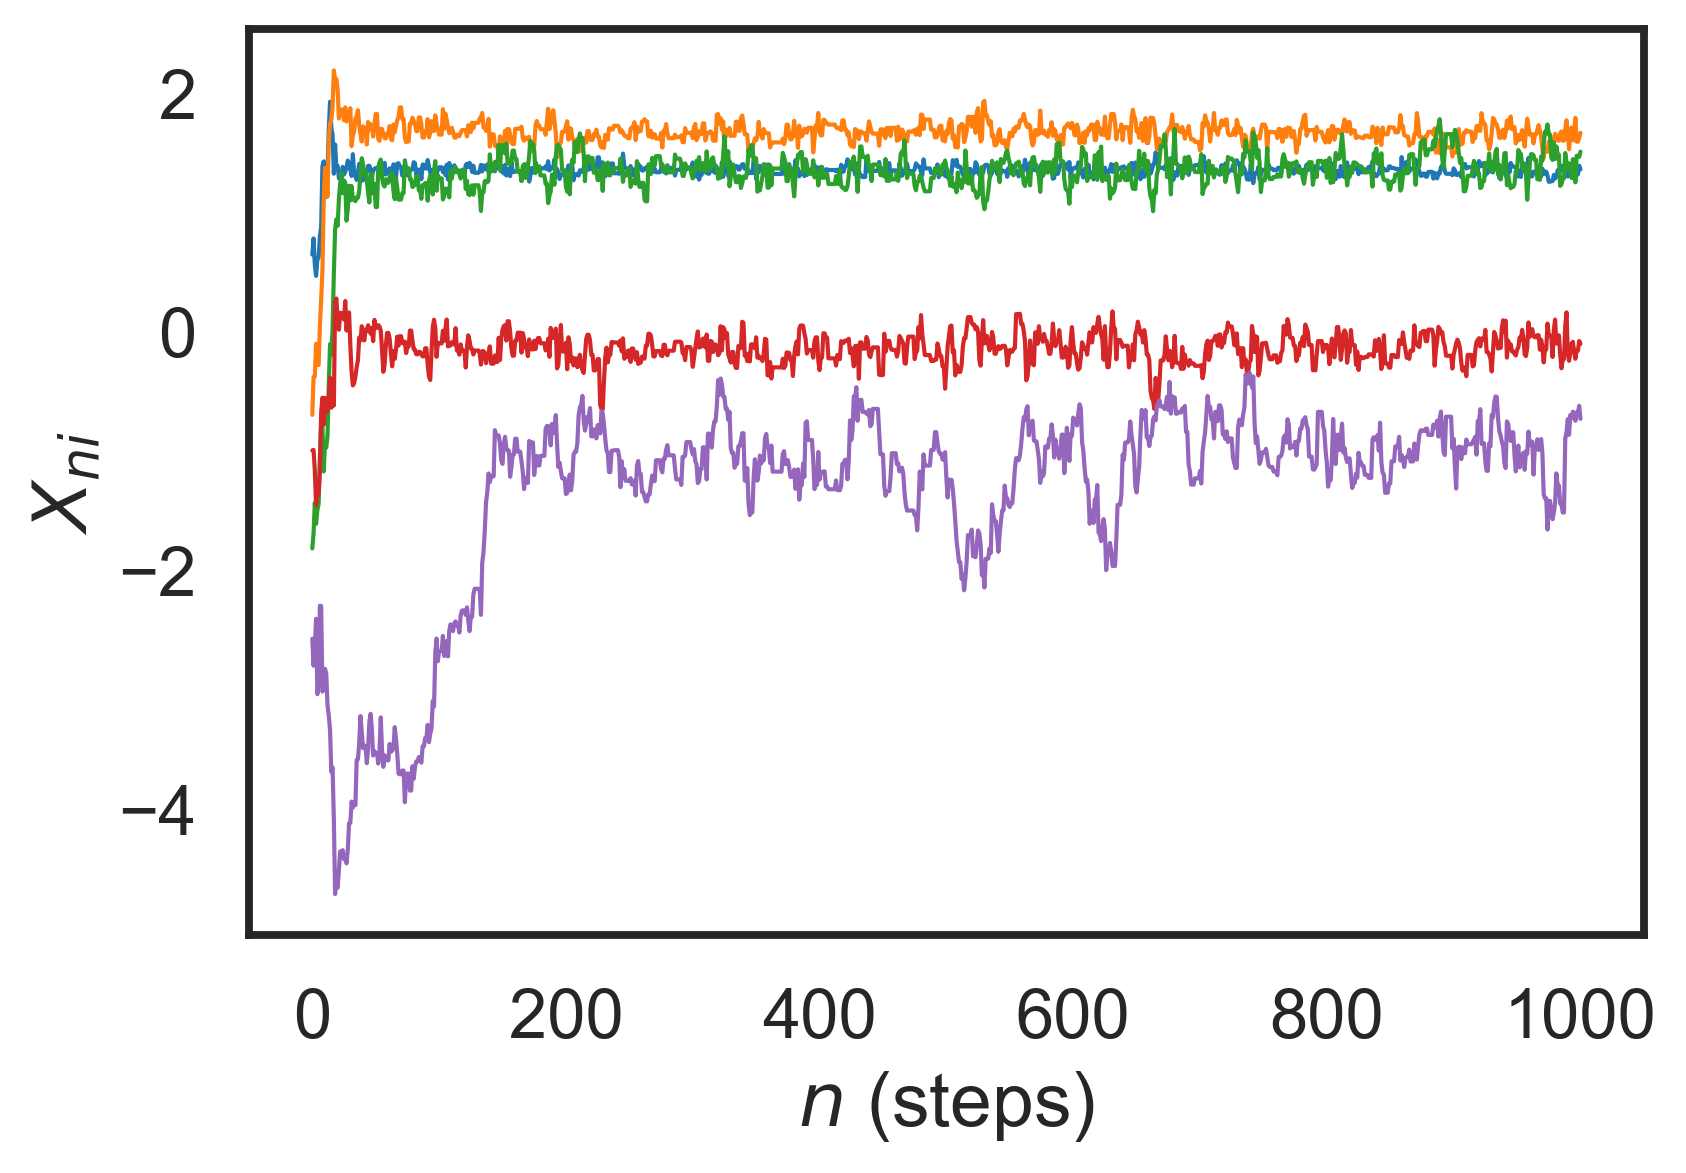

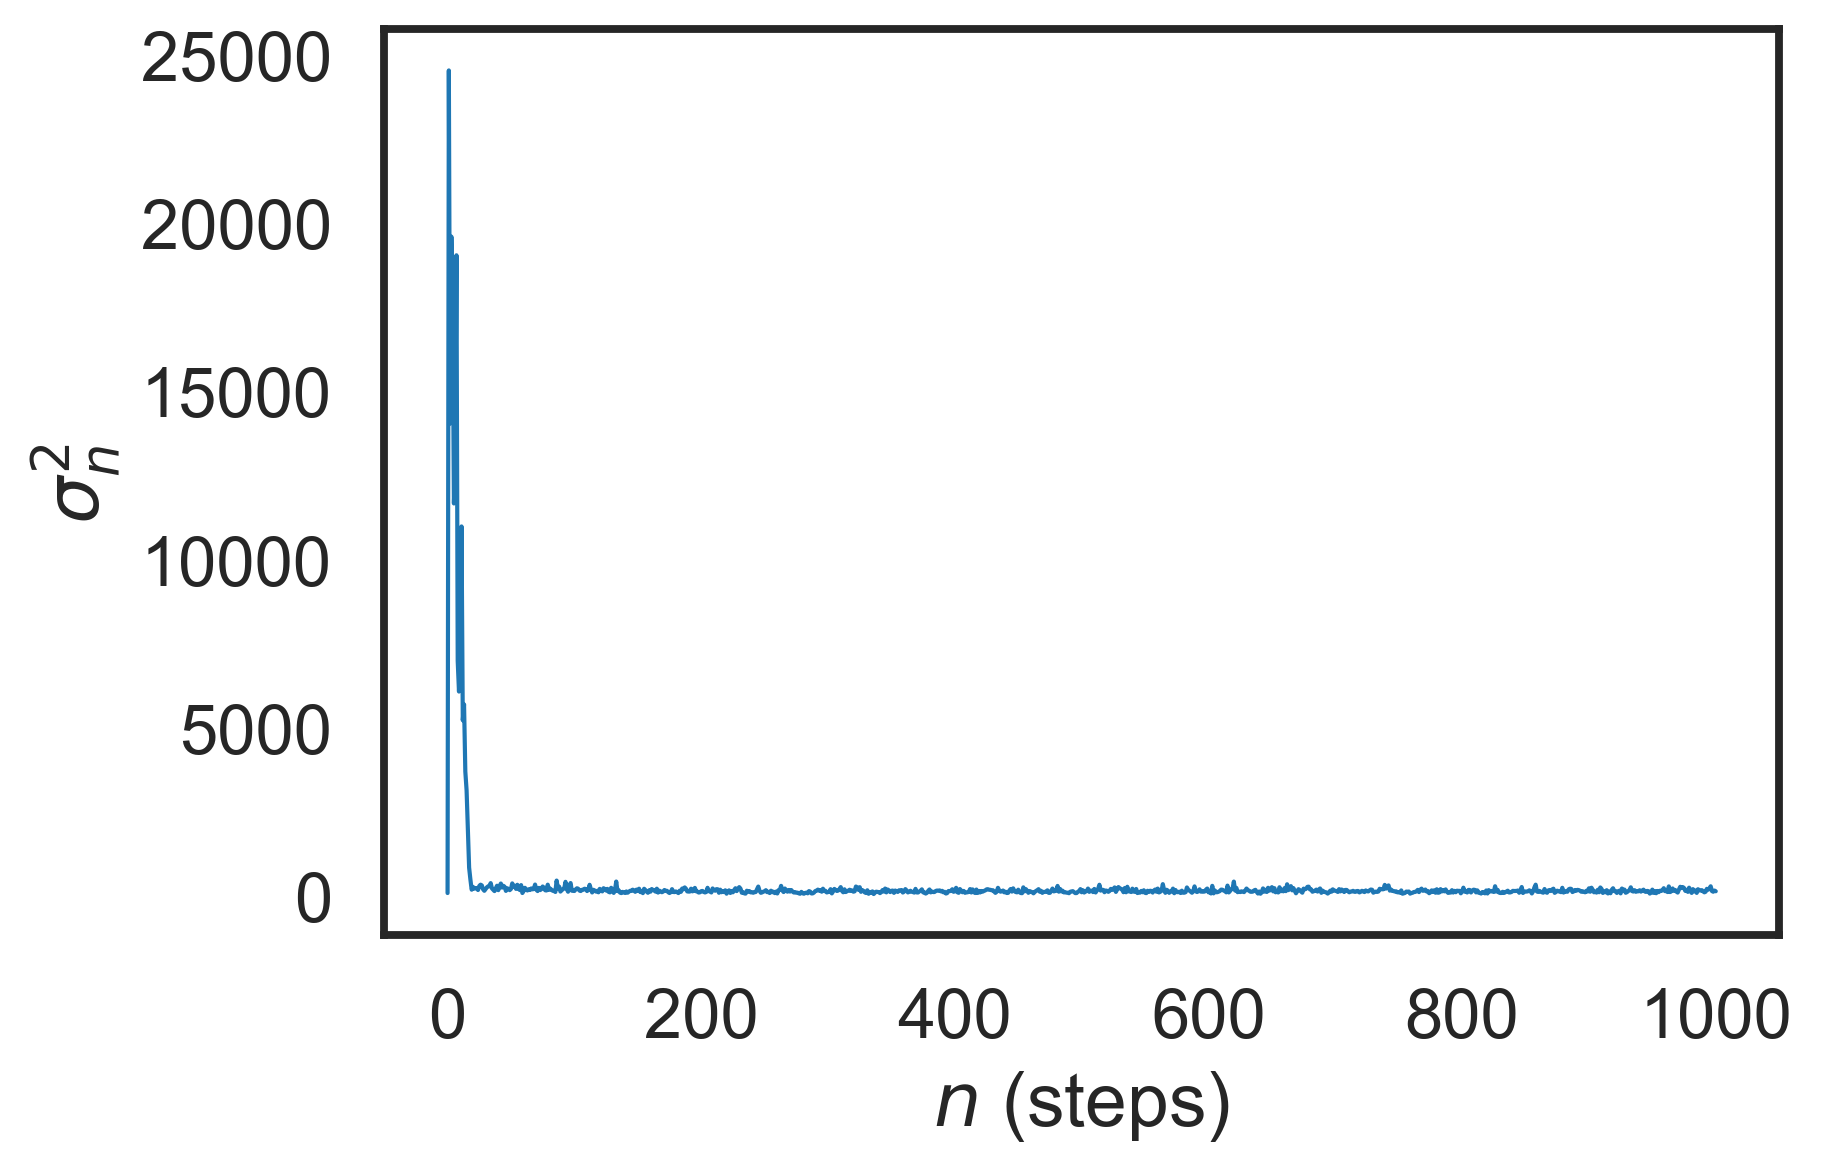

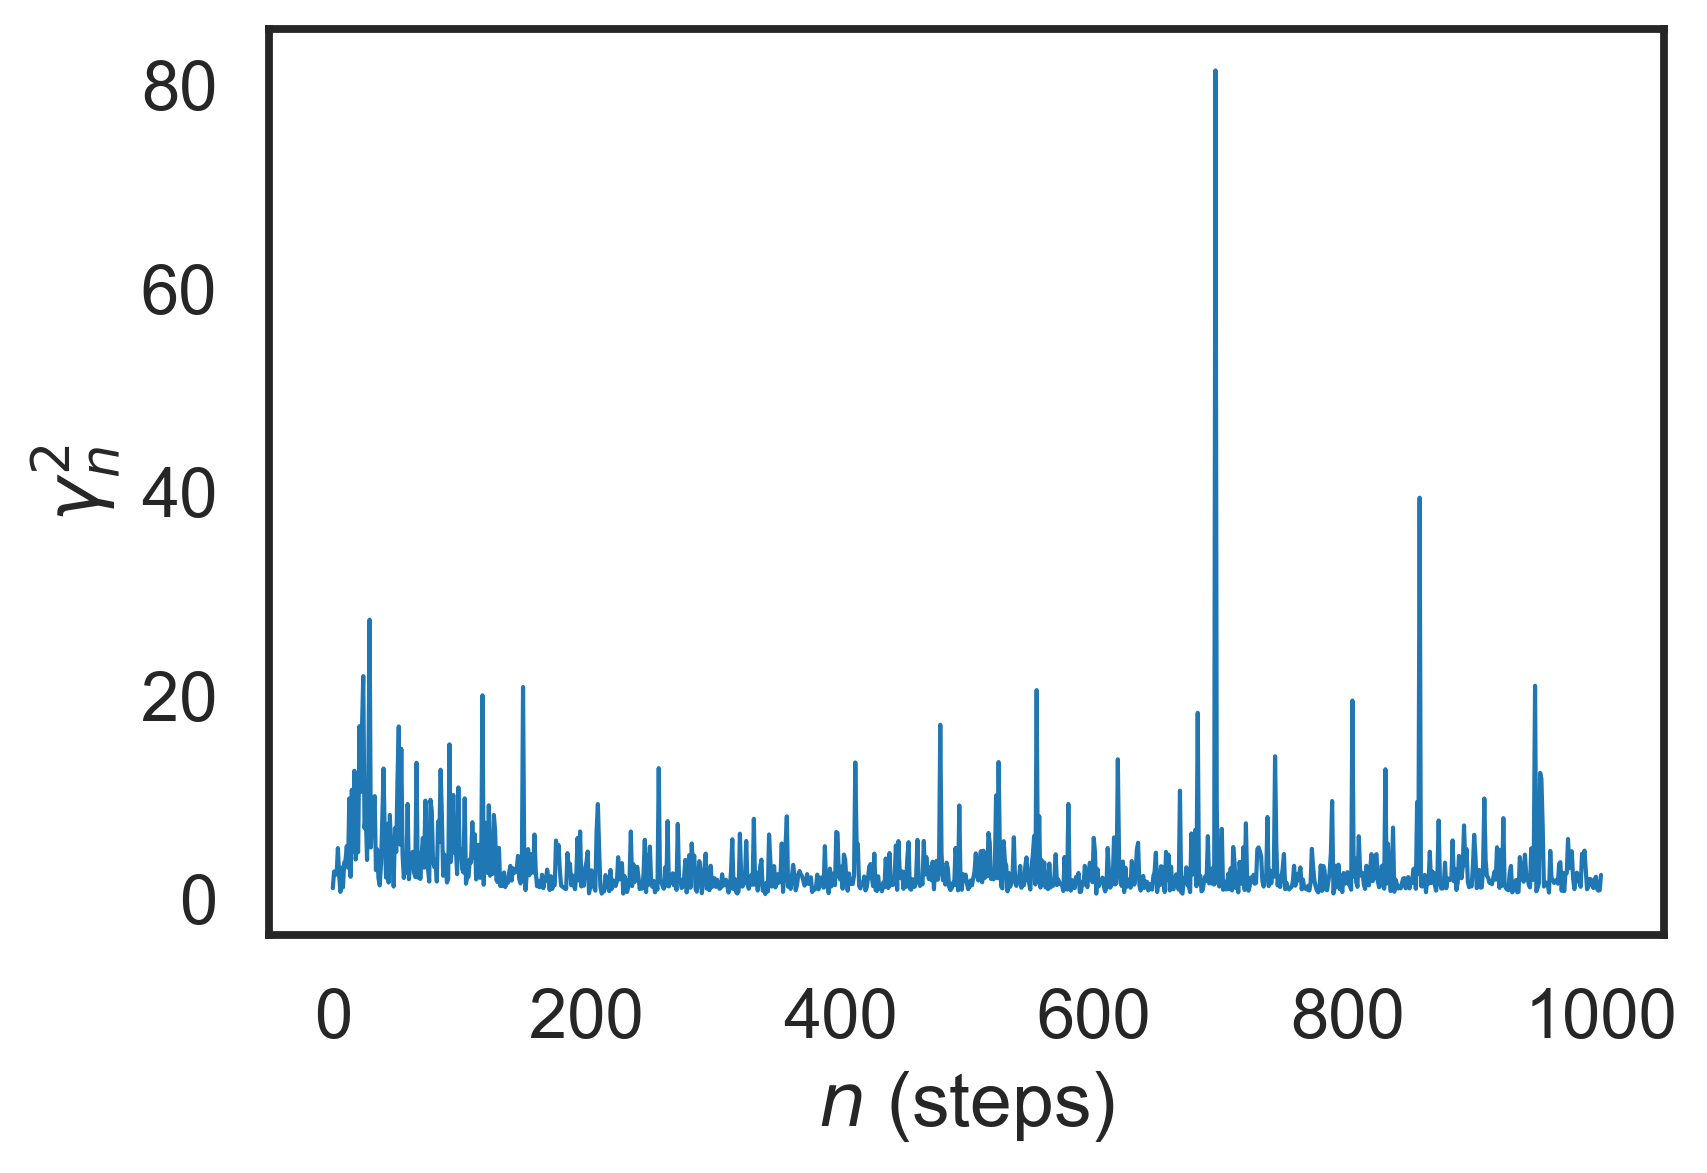

In [25]:
fig, ax = plt.subplots()
ax.plot(range(n + 1), xs, lw=1)
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$X_{ni}$');
fig, ax = plt.subplots()
ax.plot(range(n + 1), sigma2s, lw=1)
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$\sigma^2_n$');
fig, ax = plt.subplots()
ax.plot(range(n + 1), gamma2s, lw=1)
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$\gamma^2_n$');

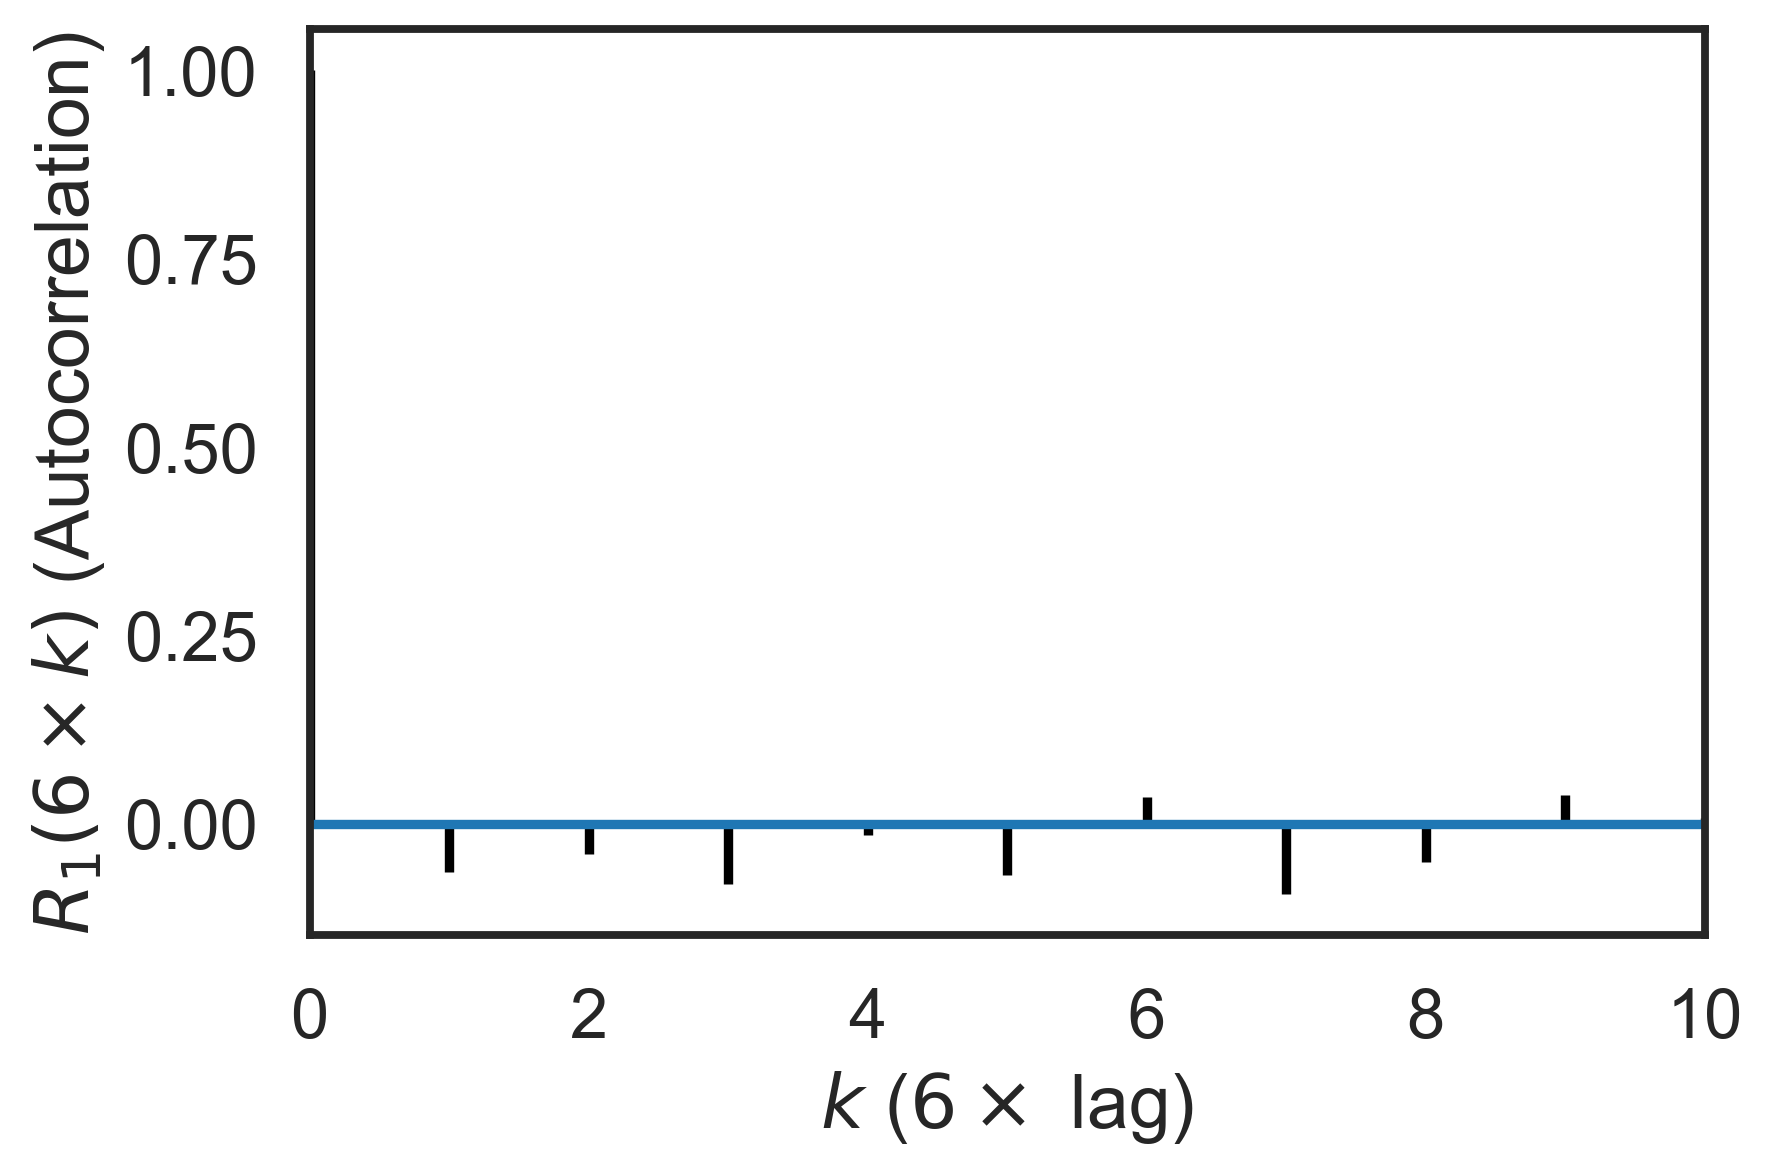

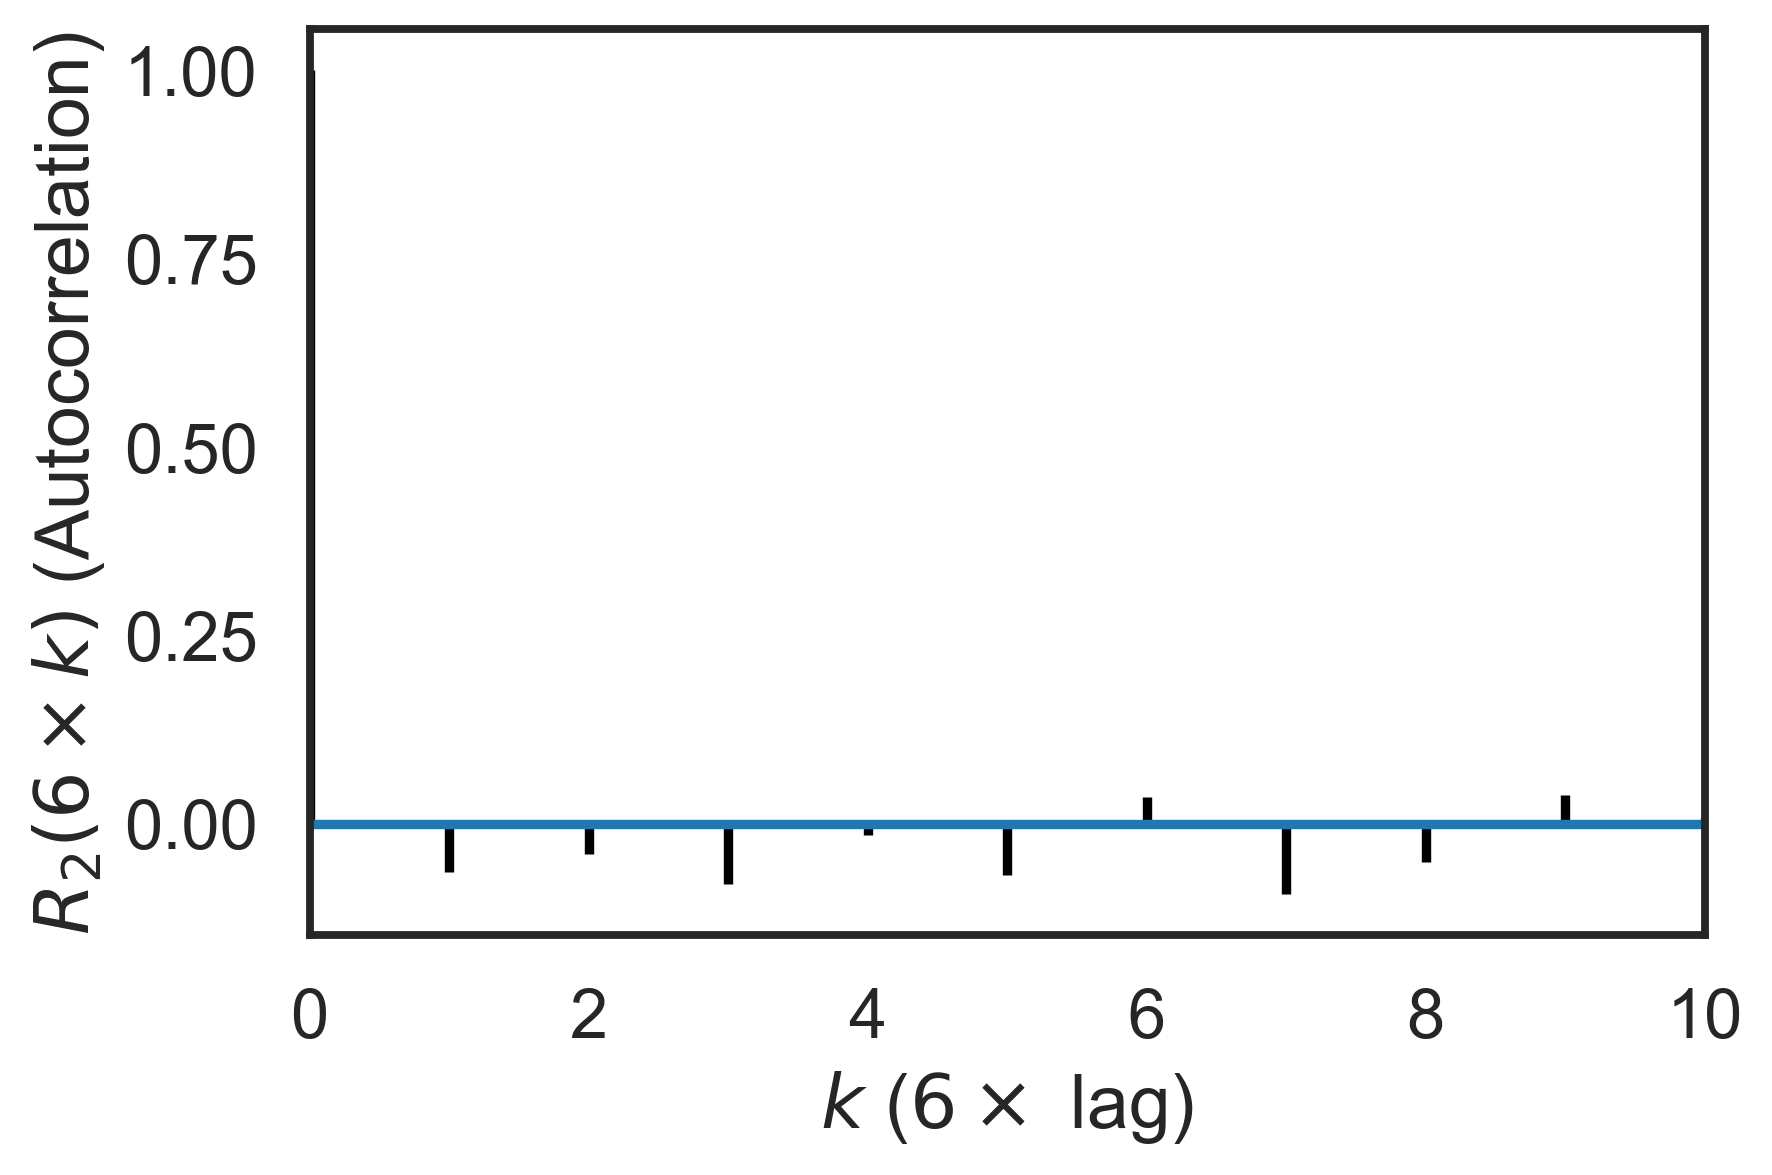

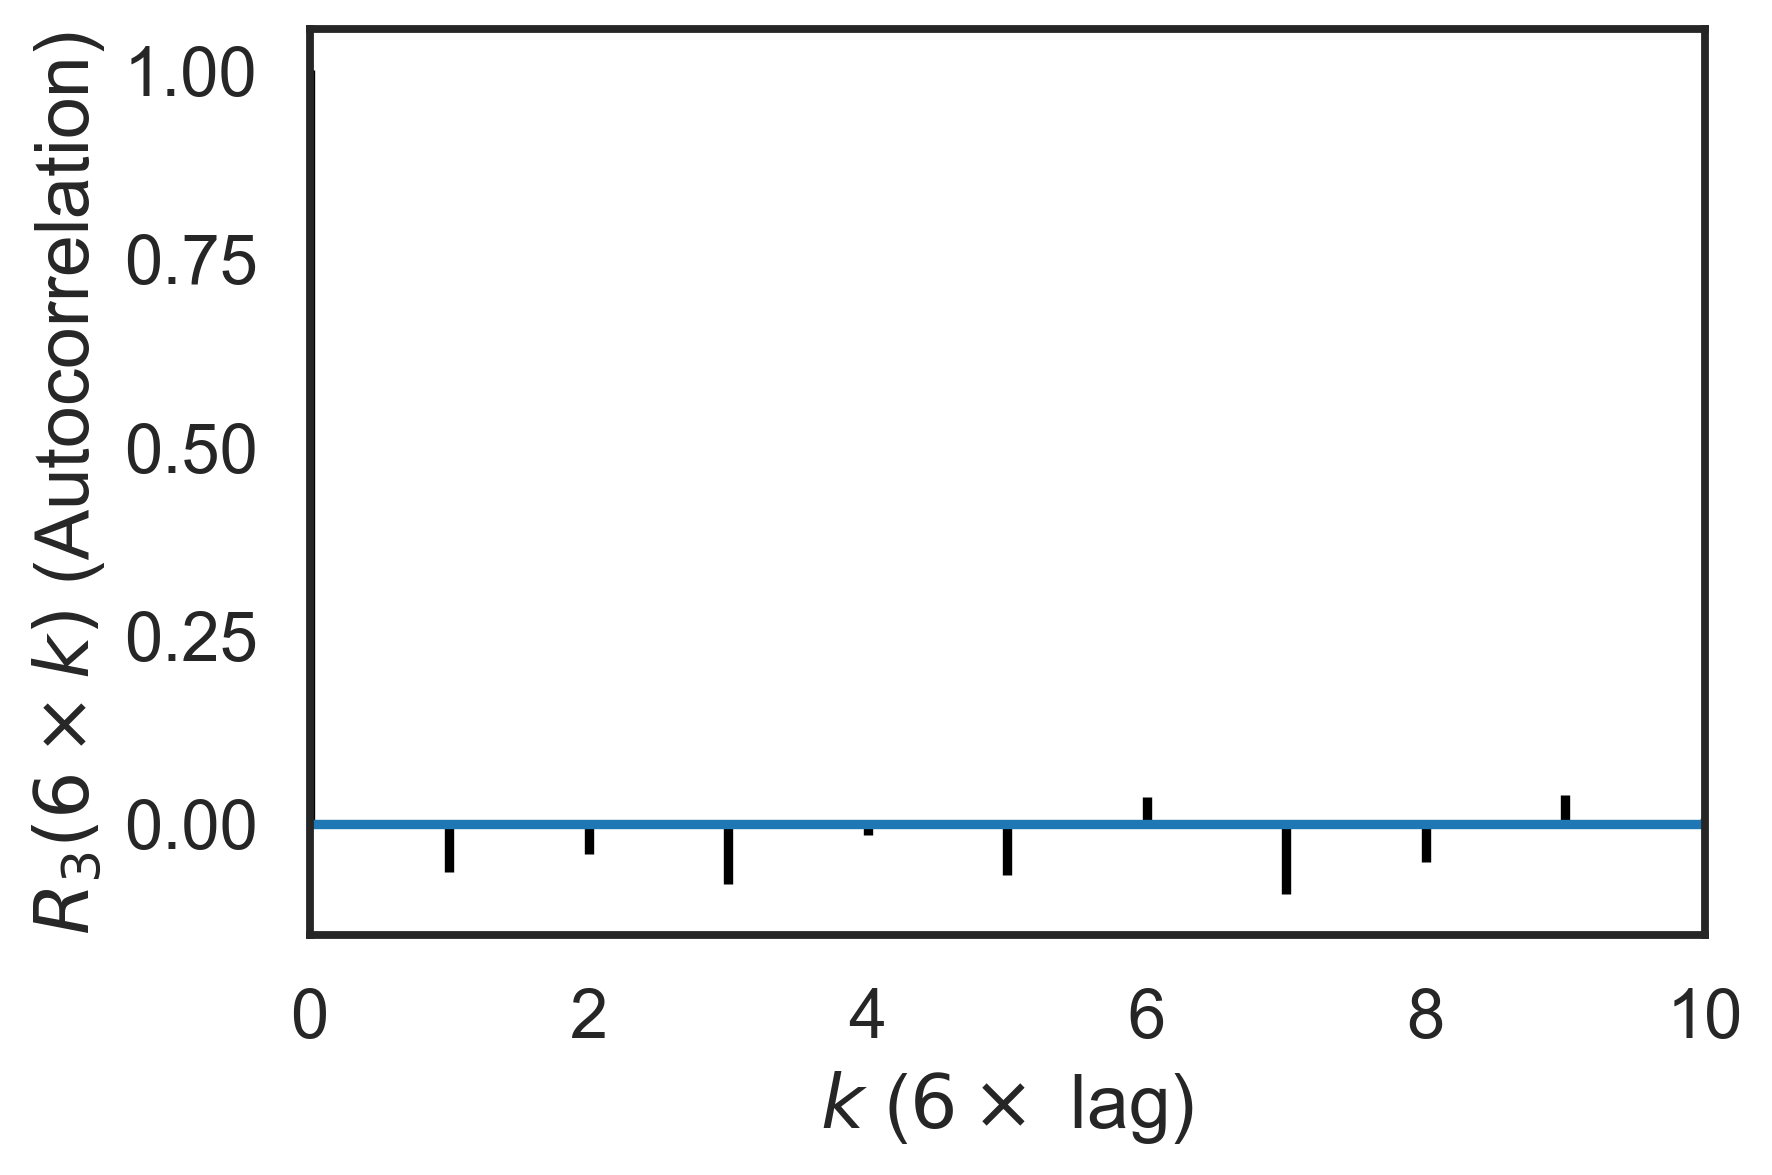

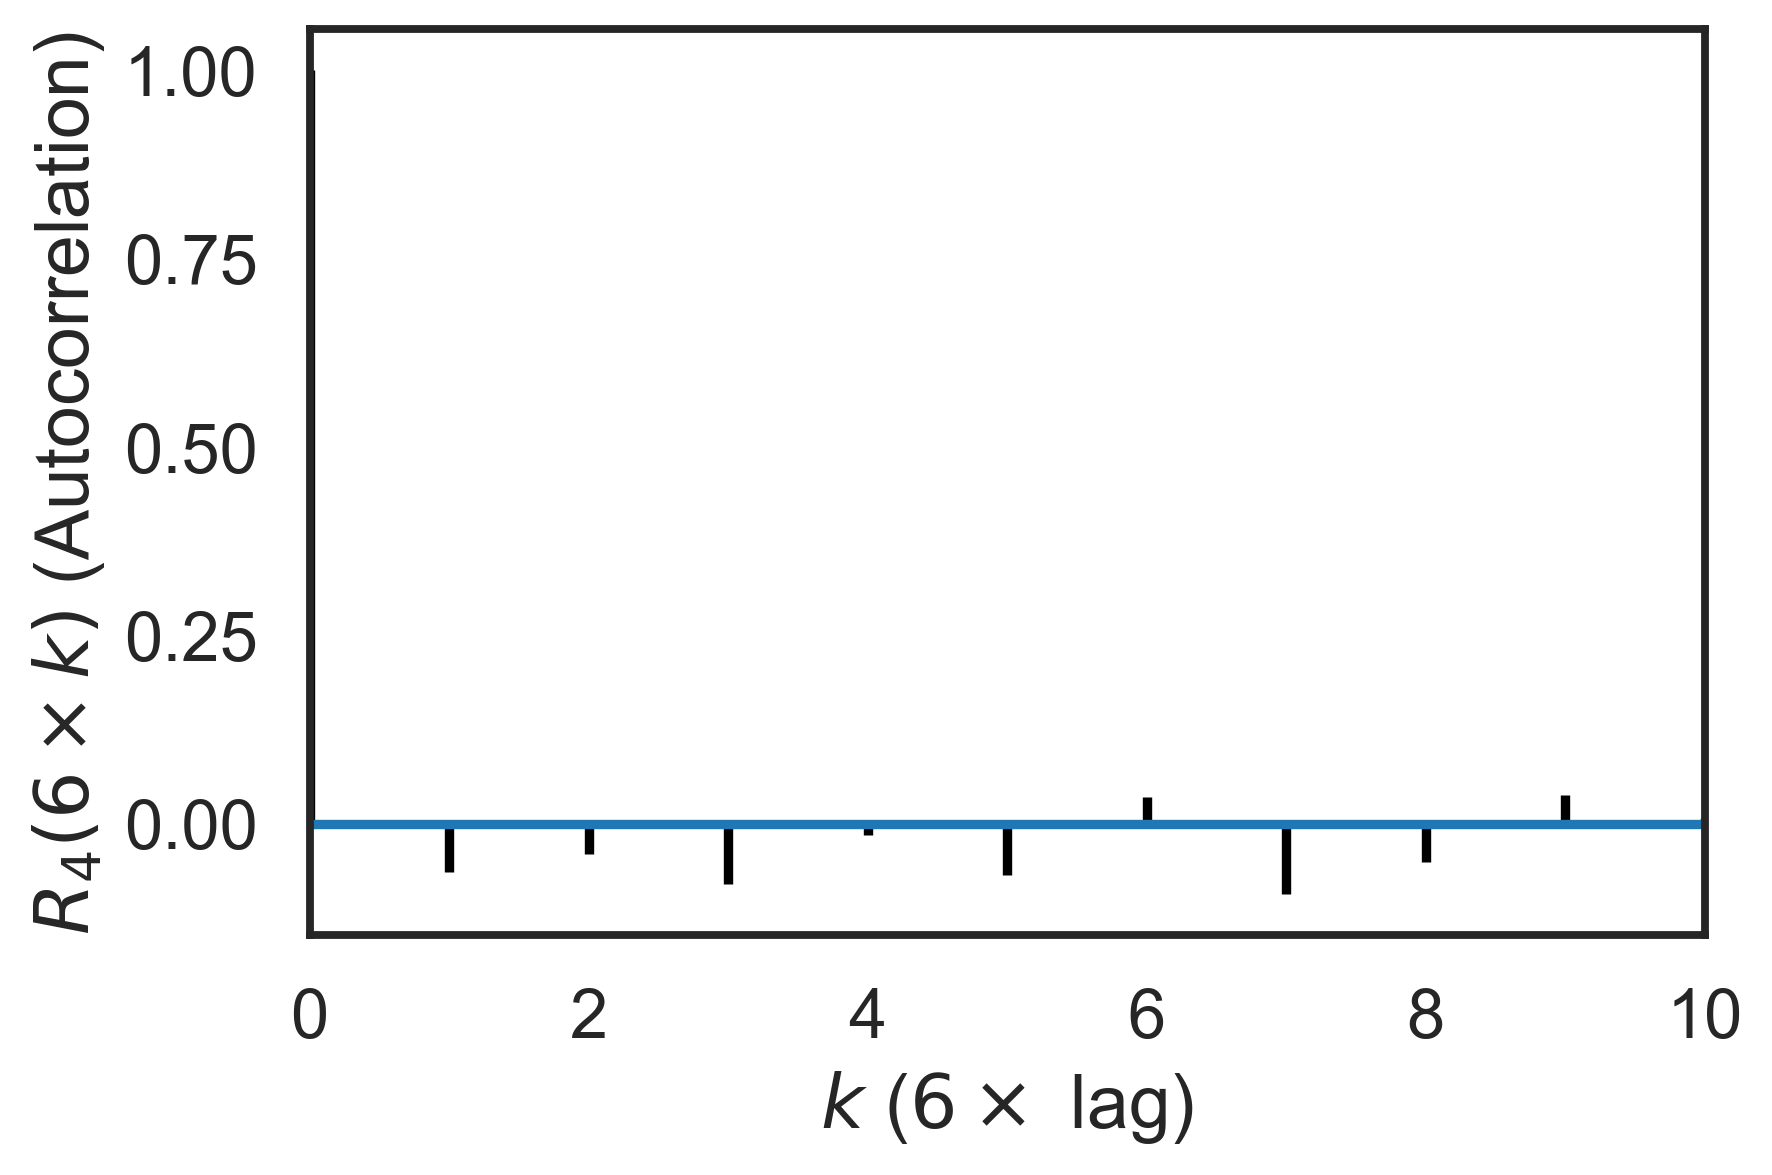

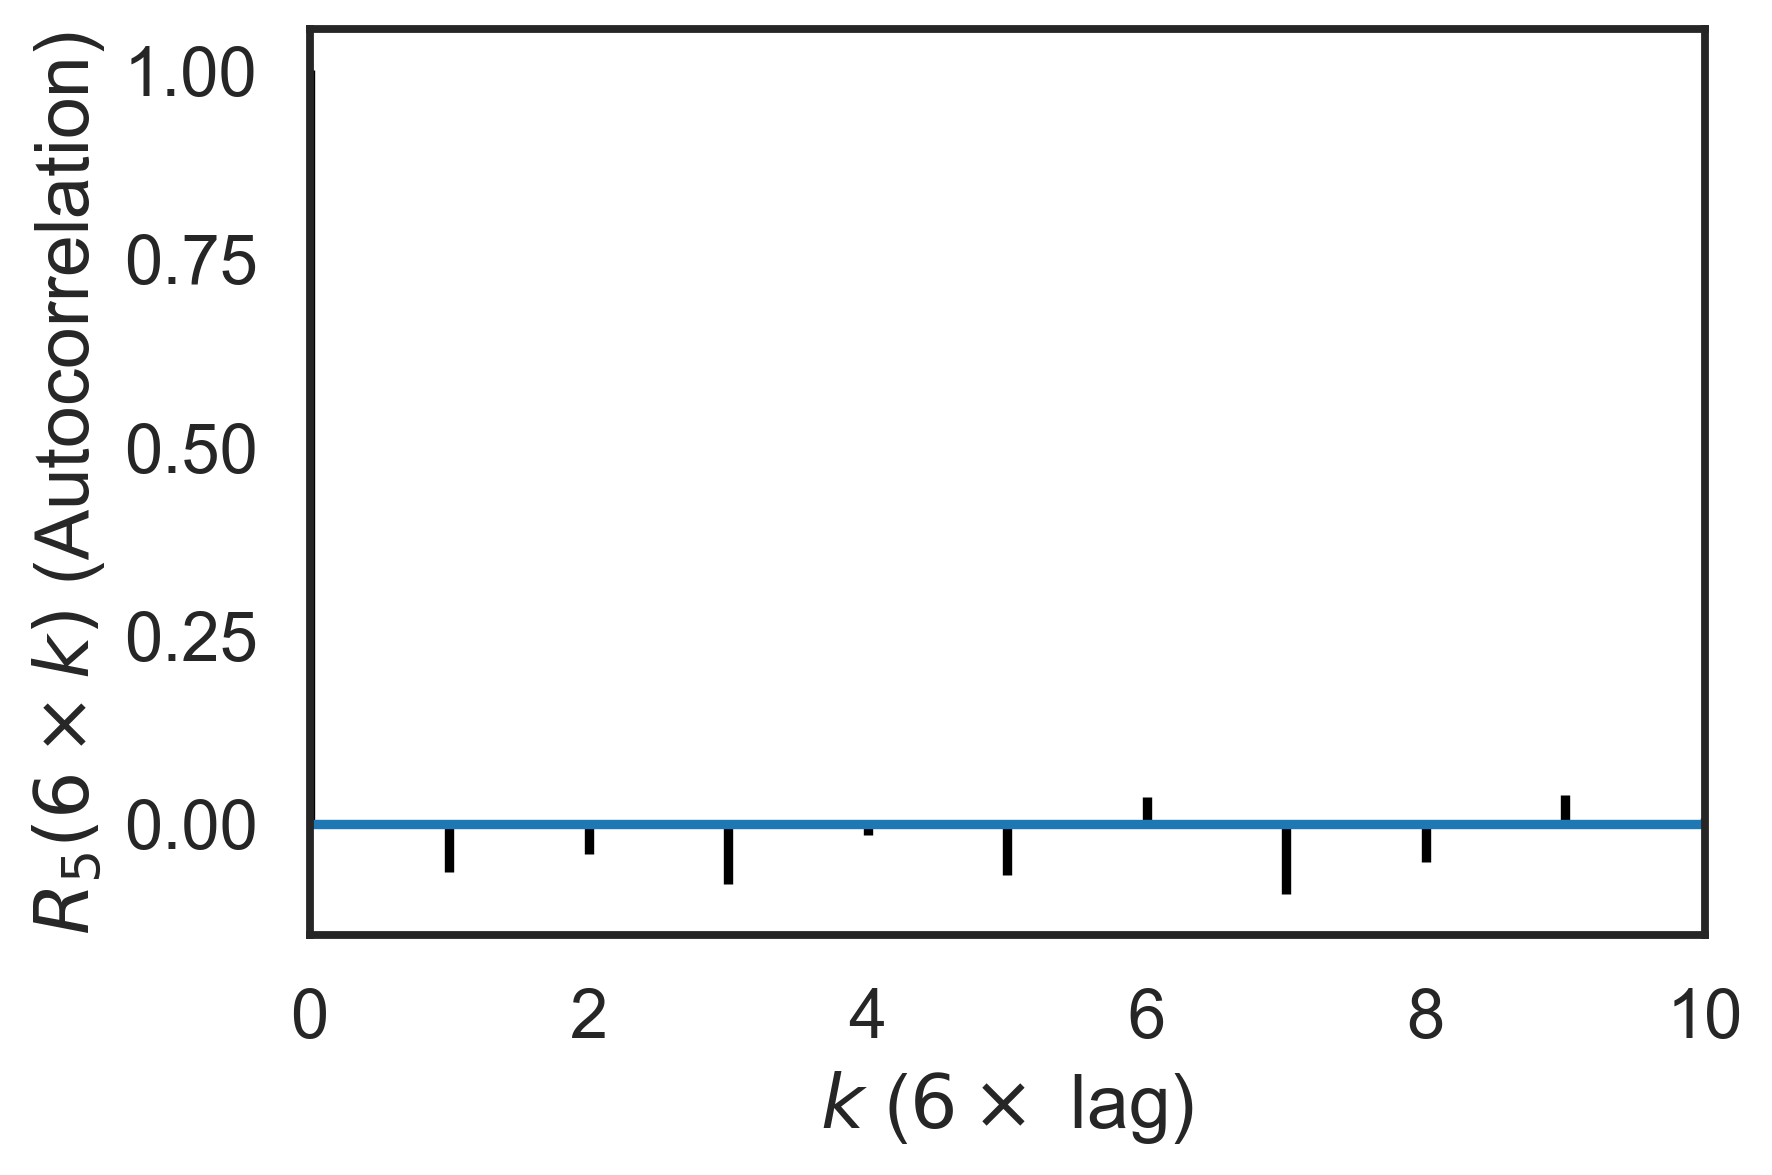

In [27]:
# How many samples do you want to burn?
burn = 10
# How many samples do you want to throw in between?
thin = 6 # Keep one every ten samples (k*)
# Here are the remaining samples:
xs_rest = np.array(xs[burn::thin])
for i in range(d):
    fig, ax = plt.subplots()
    ax.acorr(xs_rest[:, 0], detrend=plt.mlab.detrend_mean, maxlags=10)
    ax.set_xlim(0, 10)
    ax.set_ylabel(r'$R_{%d}(%d \times k)$ (Autocorrelation)' % (i + 1, thin))
    ax.set_xlabel(r'$k$ ($%d \times$ lag)' % thin);

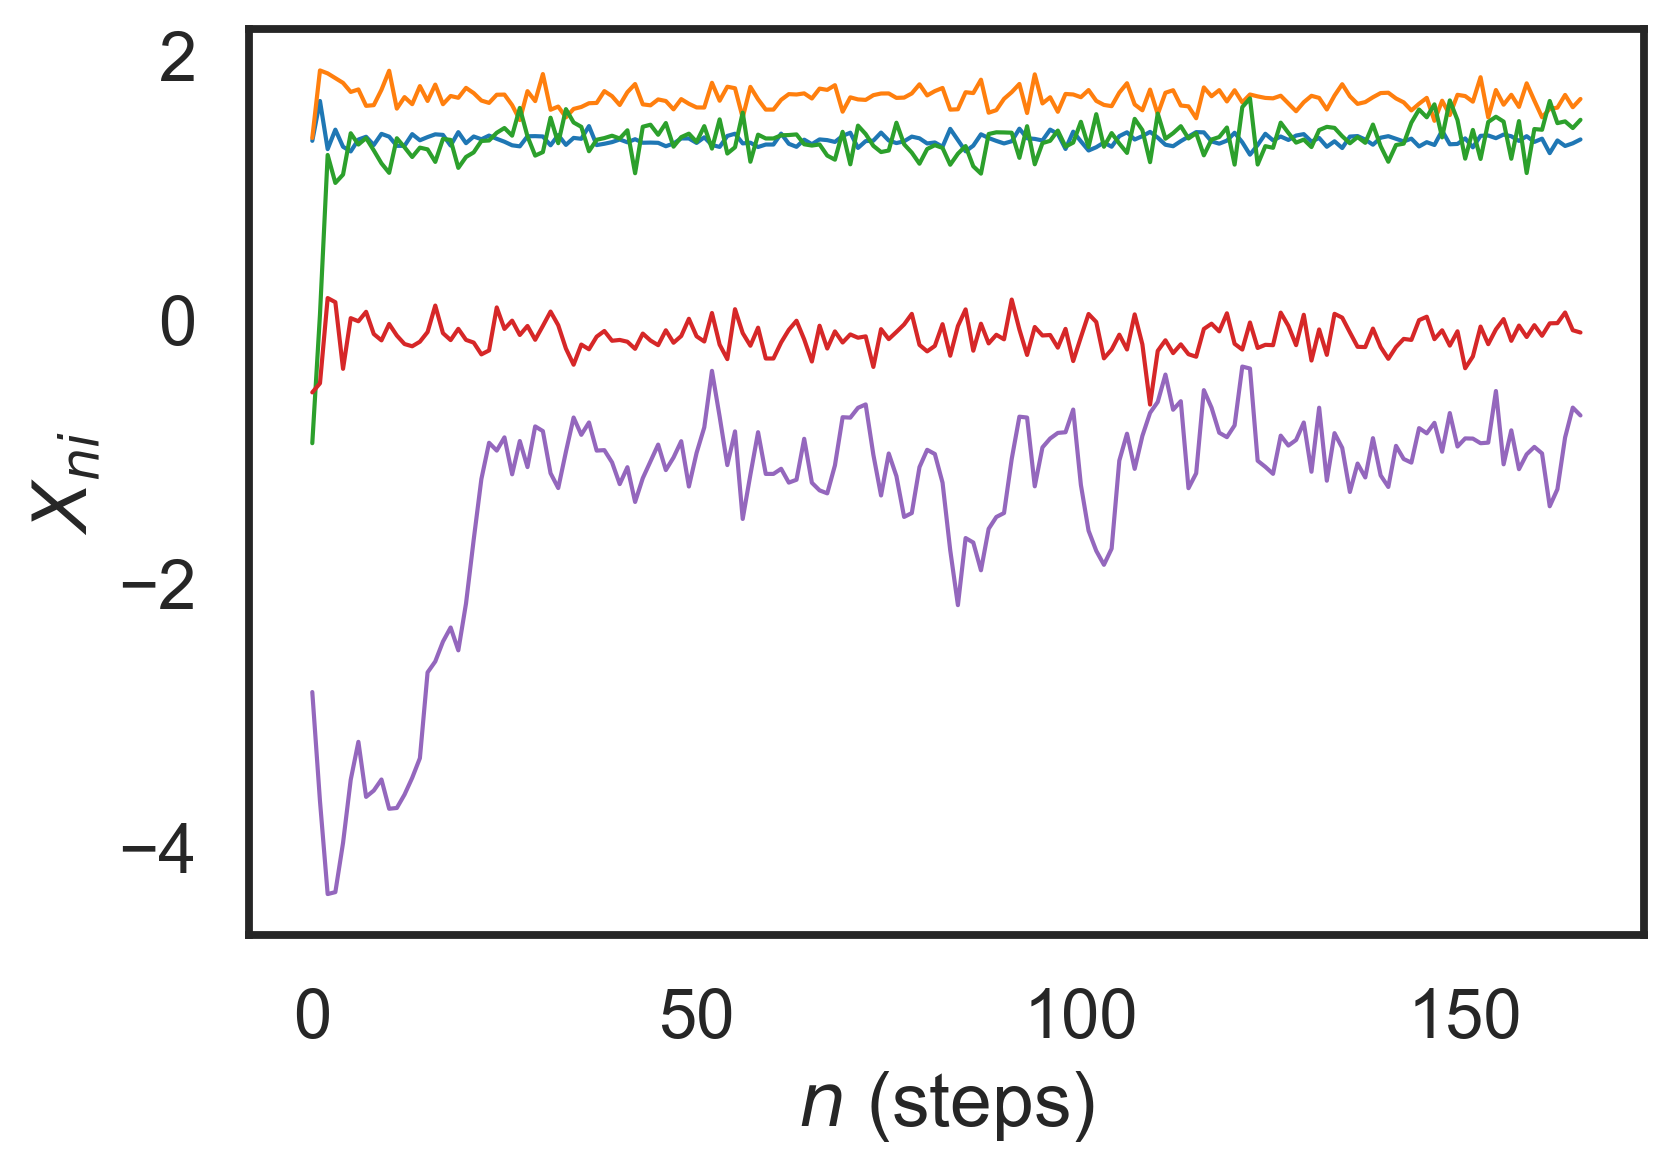

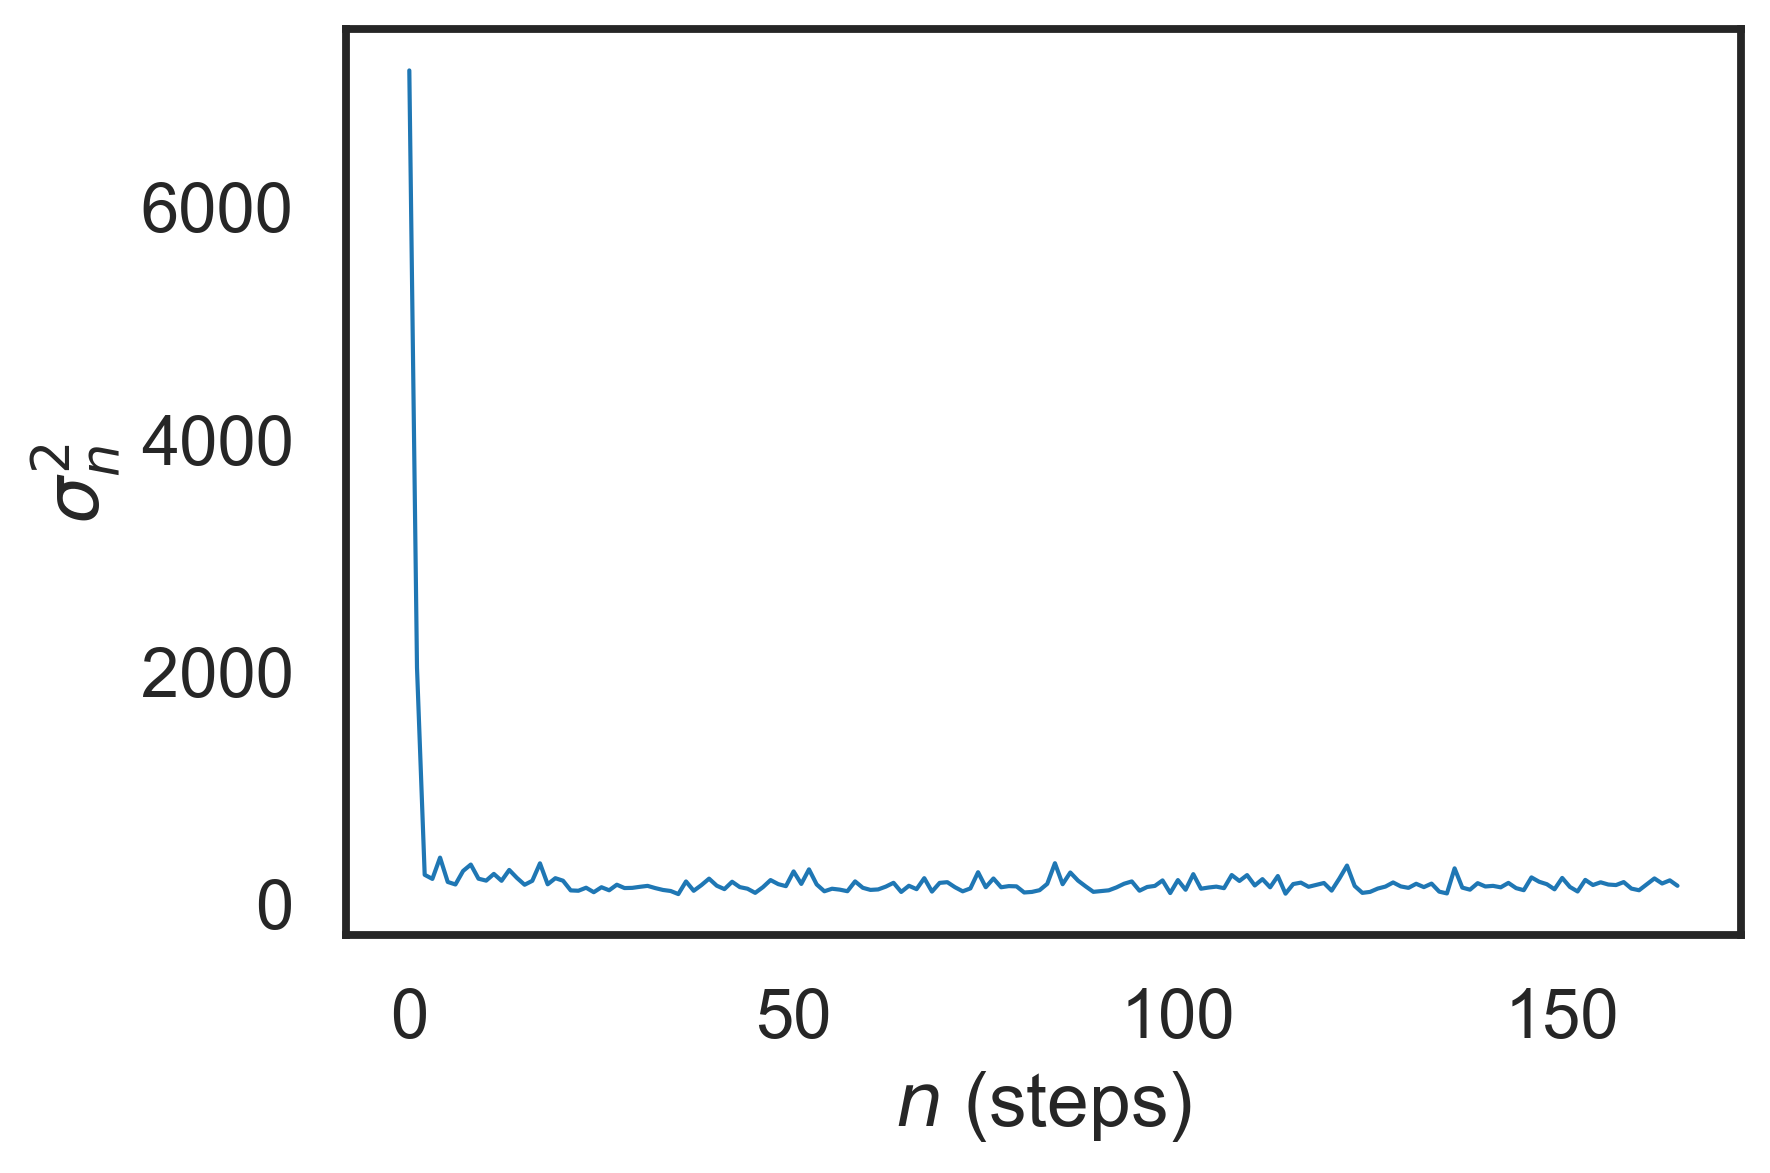

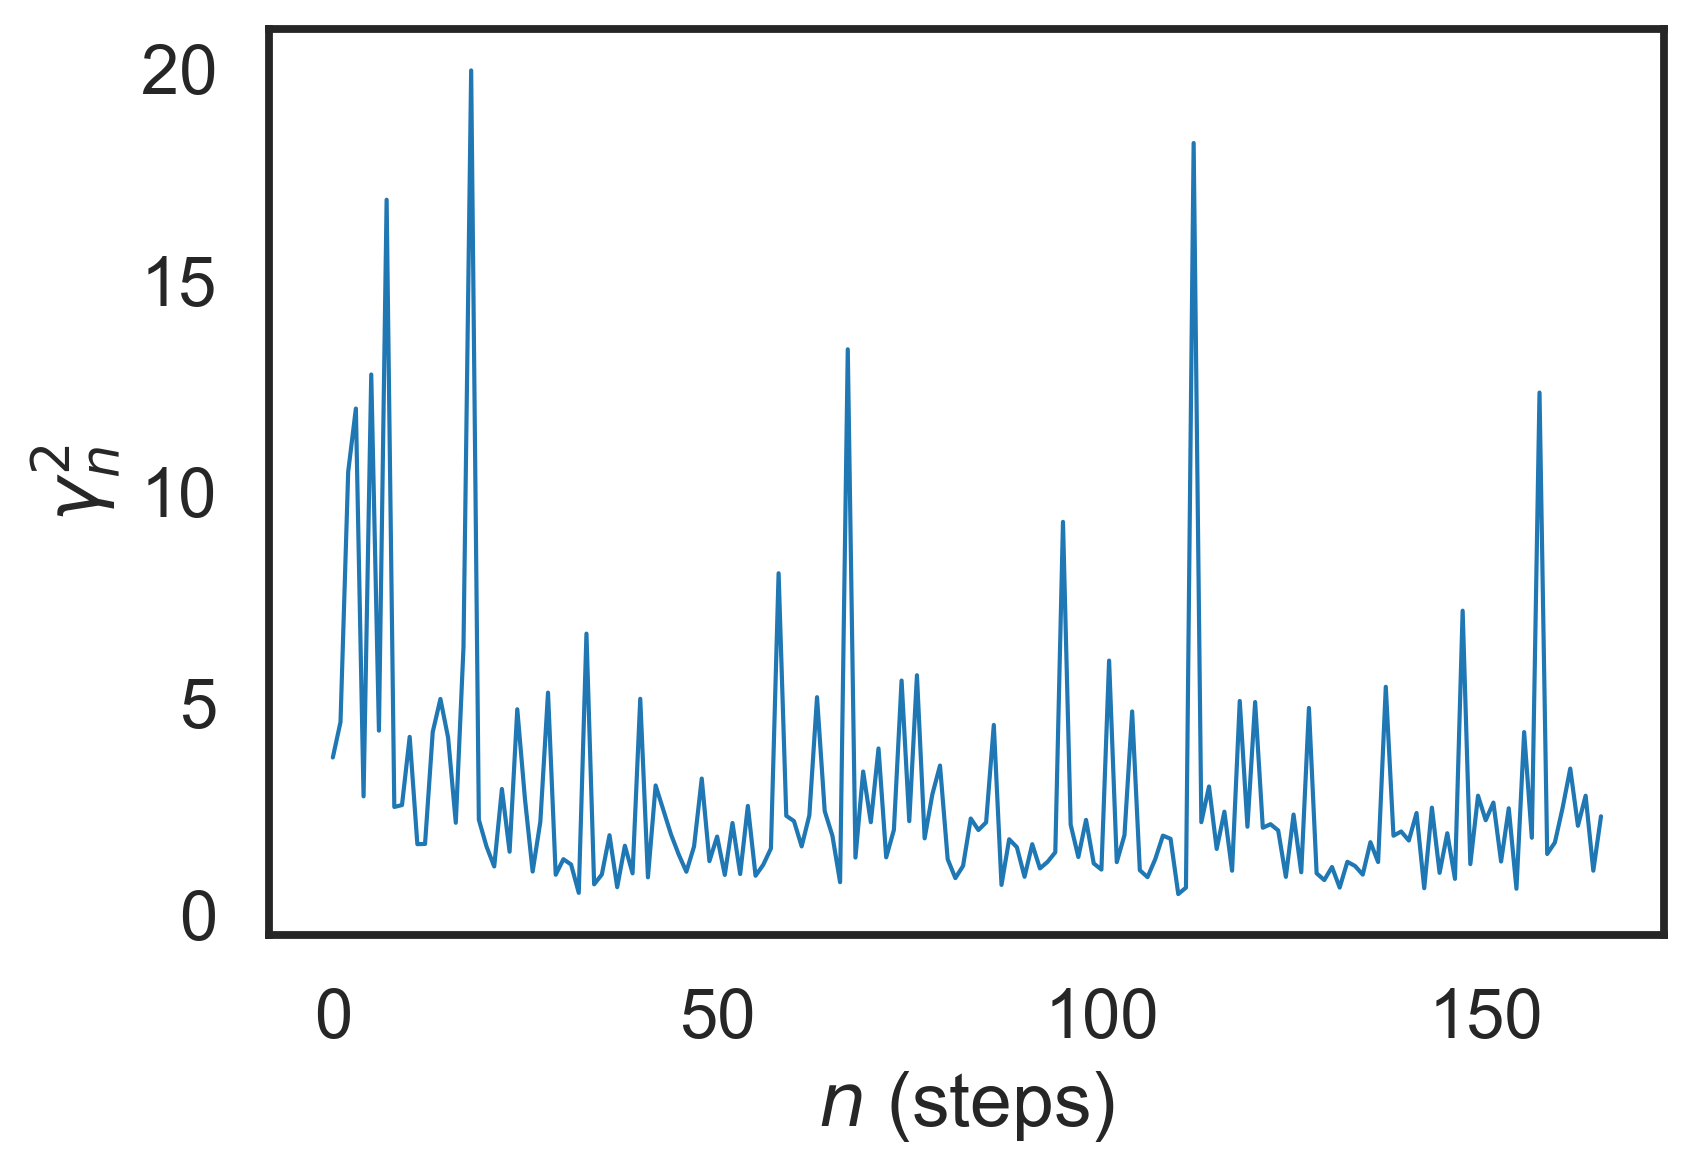

In [28]:
fig, ax = plt.subplots()
ax.plot(xs_rest, lw=1)
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$X_{ni}$');
sigma2s_rest = sigma2s[burn::thin]
fig, ax = plt.subplots()
ax.plot(sigma2s_rest, lw=1)
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$\sigma^2_n$');
gamma2s_rest = gamma2s[burn::thin]
fig, ax = plt.subplots()
ax.plot(gamma2s_rest, lw=1)
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$\gamma^2_n$');

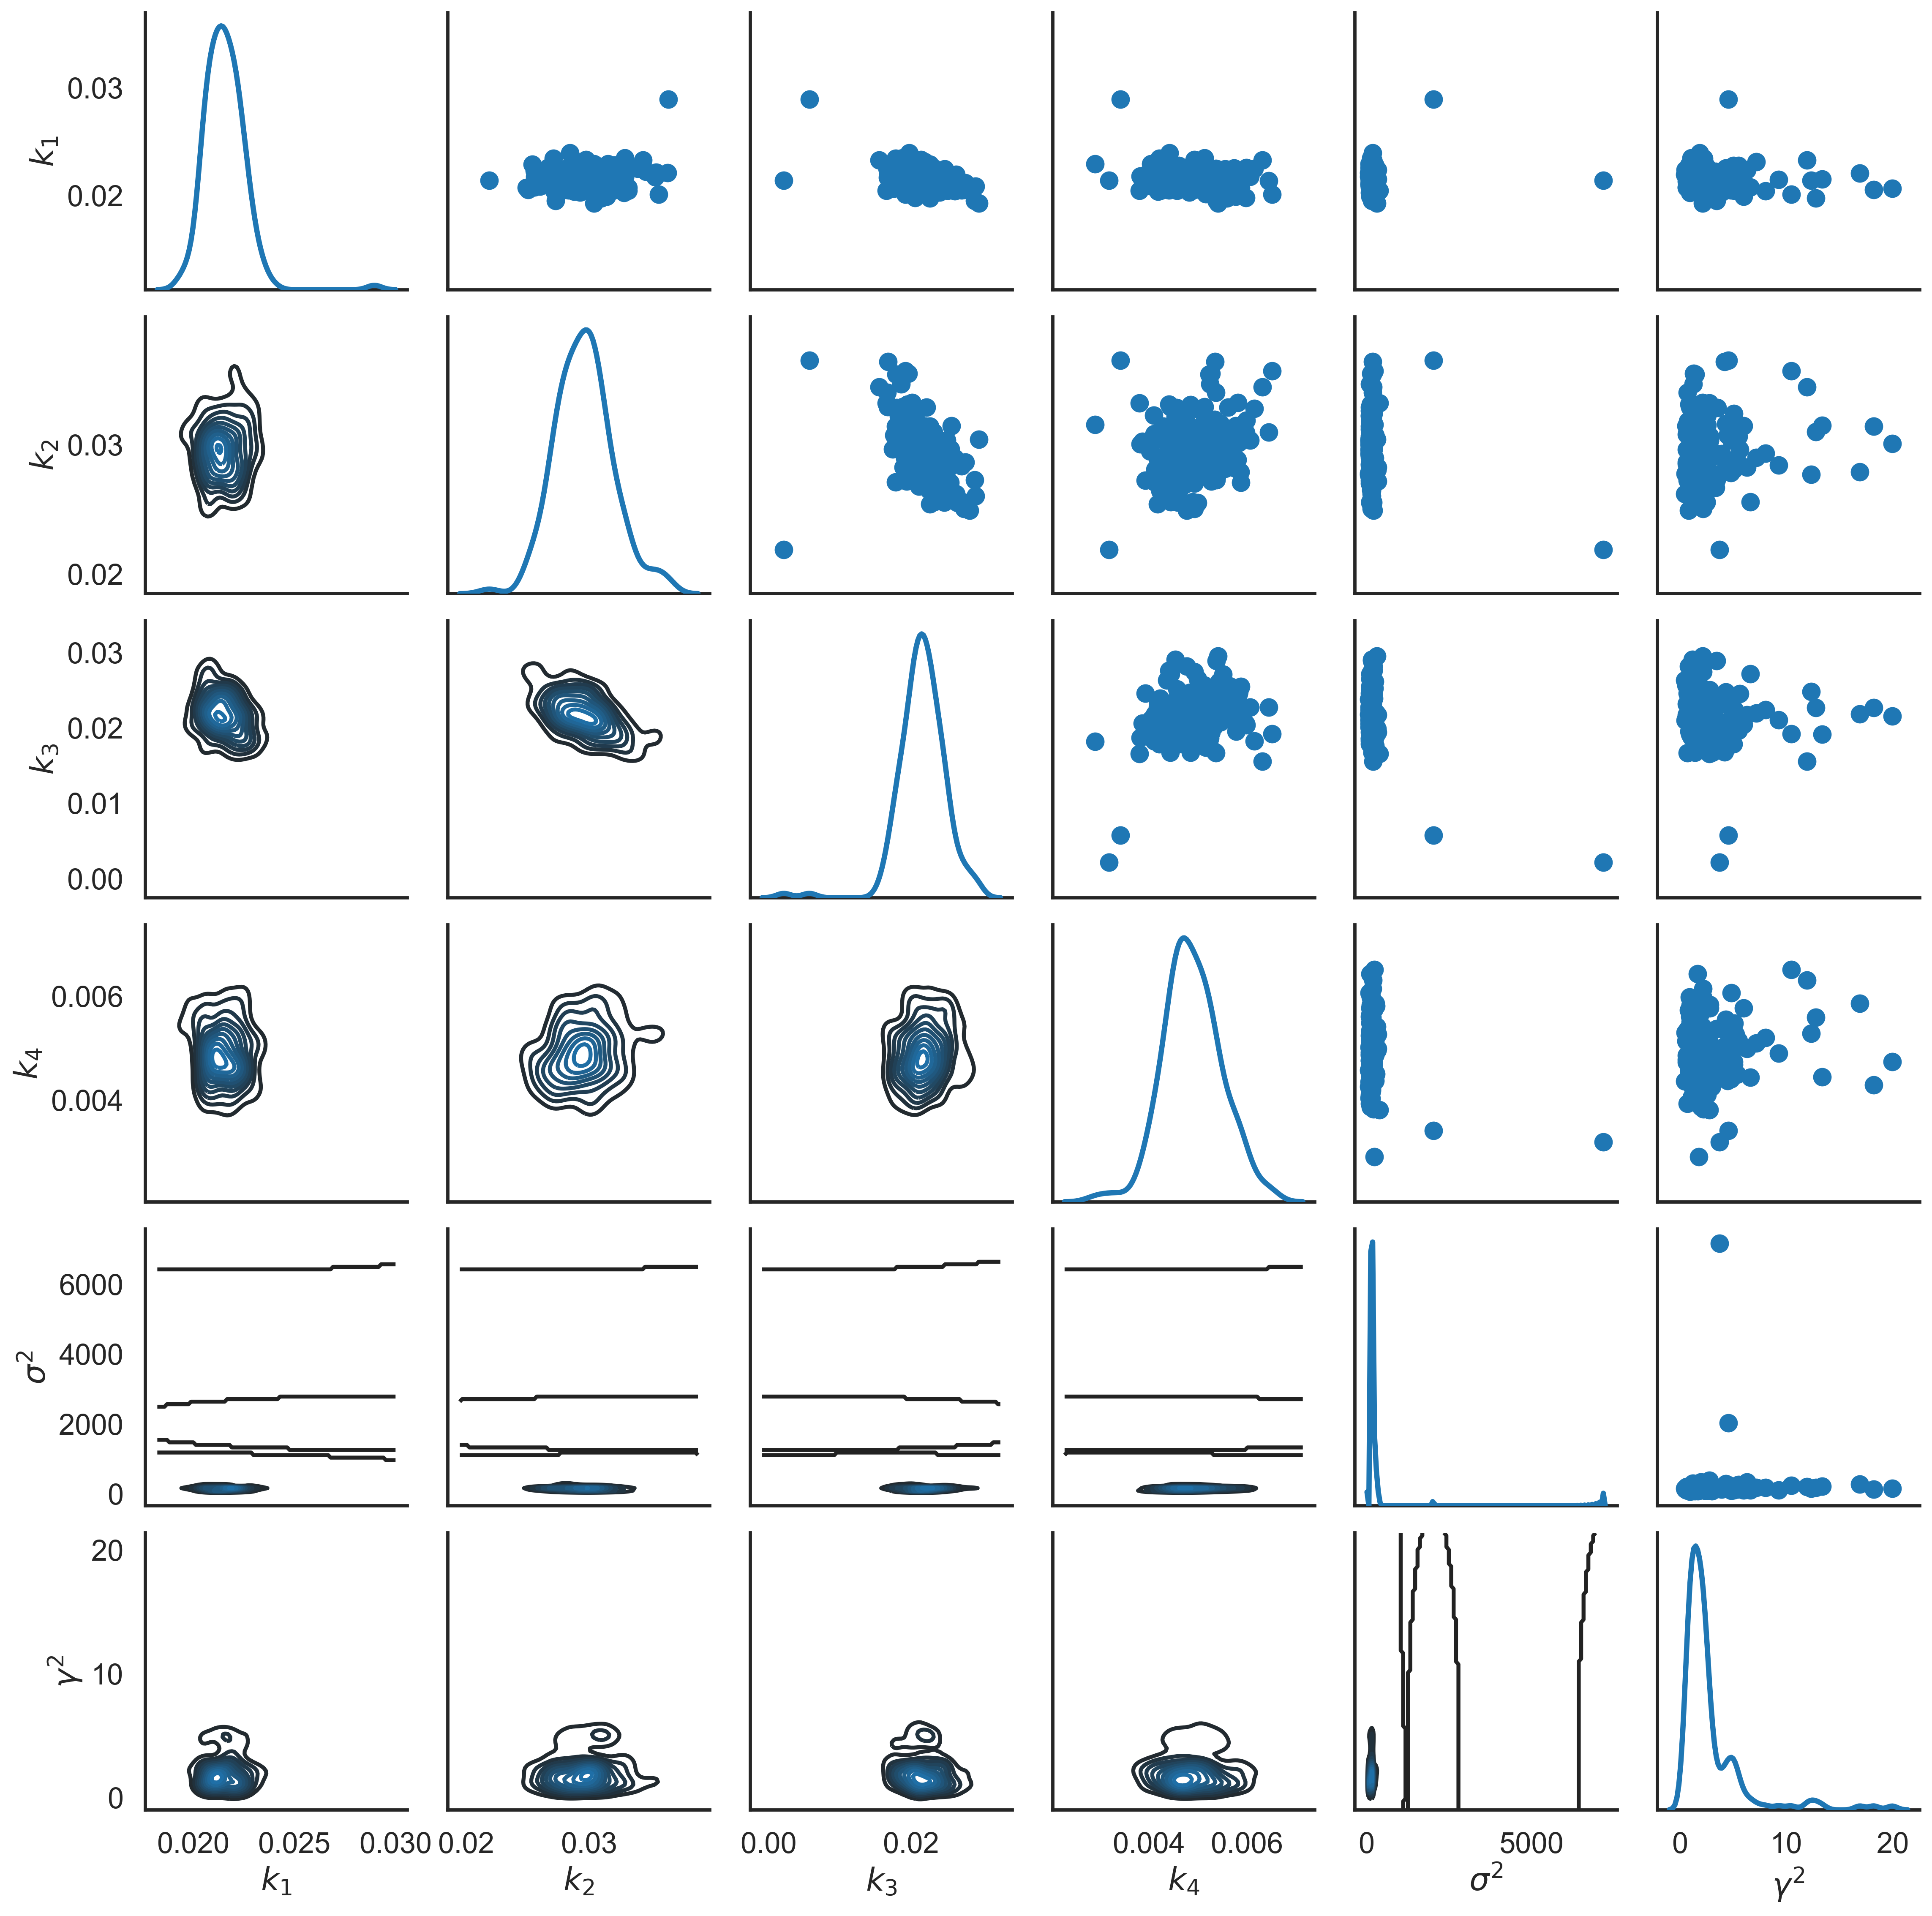

In [29]:
# Now let's plot the posterior pdf's of our k's 
K_rest = np.exp(xs_rest[:, :-1]) / 180.
Z_rest_trans = np.hstack([K_rest, np.array(sigma2s_rest)[:, None], np.array(gamma2s_rest)[:, None]])
df = pd.DataFrame(Z_rest_trans, columns=['$k_{%d}$' % (i + 1) for i in range(K_rest.shape[1])] + ['$\sigma^2$', '$\gamma^2$'])
gg = sns.PairGrid(df, diag_sharey=False)
gg.map_lower(sns.kdeplot)
gg.map_upper(plt.scatter)
gg.map_diag(sns.kdeplot, lw=3);

### Questions

+ You probably need to run the Gibbs sampler for 10 times as many steps as we did. MCMC seems to still be in the transient regime. Go ahead and do this by modifying ``n`` (the total number of steps) to 10000. However, be prepared to wait. This may be the time to go for that walk...